## In Cloud Management
This notebook is for testing how to define what data is "in cloud". It is also preparing for averages over 2-min legs of each cloud.

In [1]:
# imports from packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # gridspec for nested subfigures
import matplotlib.dates as mdates
import seaborn as sns
from global_land_mask import globe # for checking if on land
import warnings
import cartopy.crs as ccrs
import cartopy.feature as creature
import os #get a list of all directories/files
from datetime import datetime

# imports from files
import functions
import read_cdp
import read_cip_txt
import read_lwc
import read_nav
import read_cip_nc
import plots
import numb_conc
import in_cloud_detect
import read_flight_report
from data_intake import read_sic
from plots import letter_annotation

# surpress UserWarning connected to timezoneless np.datetime
warnings.filterwarnings("ignore", message="no explicit representation of timezones available for np.datetime64")
# surpress UserWrning connected to boolean series indexing (creating dataframe with null values)
warnings.filterwarnings("ignore", message="Boolean Series key will be reindexed to match DataFrame index.")

In [2]:
# --- Global formatting/settings/variables

# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')

In [3]:
# --- Data import
# Based on scripts in files read_*.py

# Navigational data
# -- nav_df: data variables
# -- nav_stats_dict: statistics for each flight
nav_df, nav_stats_dict = read_nav.read_nav()

# CDP data
# -- cdp_bulk_df: Bulk variables per flight
# -- cdp_bins_df: Bin details (max, min size)
# -- cdp_var_df: Variable information (names, units)
# -- cdp_meta_df: Metadata/instrument settings
cdp_bulk_df, cdp_bins_df, cdp_var_df, cdp_meta_df = read_cdp.read_cdp(nav_df)

# CIP data txt file
#cip_binneddata_df, cip_bins_df, cip_var_df, cip_proc_dict = read_cip_txt.read_cip_txt()   # CIP:  conc per bin, from txt file

# CIP data nc file
# -- cip_bulk_calc_df: Bulk variables per flight
# -- cip_conc_df: Concentration per bin
# -- cip_varnc_df: Variable, longname and unit
cip_bulk_calc_df, cip_conc_df, cip_varnc_df = read_cip_nc.read_cip_nc()    # CIP calculated bulk information                                                                 #       variable information, processing information

# LWC data
# -- lwc_bulk_df: 
# -- lwc_meta_df:
# -- lwc_chan_dict:
#lwc_bulk_df, lwc_meta_df, lwc_chan_dict = read_lwc.read_lwc(nav_df)

# Flight report data:
# -- report_cloud_df: flight report information
# -- flights: list of flightnames
#report_cloud_df, flights = read_fligth_reports_all.read_fligth_reports_all()

----Reading CDP files:
Reading: ../2022-islas/as220014/microphy/pads/20220403071511/02CDP 20220403071511.csv
Reading: ../2022-islas/as220009/microphy/pads/20220326080106/02CDP 20220326080106.csv
Reading: ../2022-islas/as220010/microphy/pads/02CDP 20220326133751.csv
Reading: ../2022-islas/as220007/microphy/pads/20220324080247/02CDP 20220322105458.csv
Reading: ../2022-islas/as220015/microphy/pads/20220403123534/02CDP 20220403123534.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324080247/02CDP 20220324080247.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324113123/02CDP 20220324113123.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324130909/02CDP 20220324130909.csv
Reading: ../2022-islas/as220013/microphy/pads/20220331093304/02CDP 20220331093304.csv
Reading: ../2022-islas/as220011/microphy/pads/02CDP 20220329081432.csv
Reading: ../2022-islas/as220012/microphy/pads/20220330135853/02CDP 20220330135853.csv
Reading: ../2022-islas/as220012/microphy/pads/20220330134834/

In [4]:

# -- Join the relevant columns from the nav, the cip, and the cdp data
# select time and number concentration columns from cip and cdp
# sort by time to help joining
# CIP IWC, LWC etc have been calculated for particles >100 mum
cip_df = cip_bulk_calc_df[['time', 'NT (#/m3)','IWC (gram/m3)','LWC (gram/m3)']].sort_values(by='time', axis=0)
cdp_df = cdp_bulk_df[['time', 'Number Conc corr (#/cm^3)', 'LWC corr (g/m^3)','MVD (um)','Number Conc (#/cm^3)', 'LWC (g/m^3)']].sort_values(by='time', axis=0)

# rename columns to identify instrument and standardize units
cip_df = cip_df.rename(columns={'NT (#/m3)':'cip NumConc (#/m^3)','IWC (gram/m3)':'cip IWC (g/m^3)','LWC (gram/m3)':'cip LWC (g/m^3)'})
cdp_df = cdp_df.rename(columns={'Number Conc corr (#/cm^3)': 'cdp NumConc corr (#/cm^3)', 'LWC corr (g/m^3)':'cdp LWC corr (g/m^3)',
                                'MVD (um)': 'cdp MVD (um)','Number Conc (#/cm^3)': 'cdp NumConc (#/cm^3)', 'LWC (g/m^3)':'cdp LWC (g/m^3)'})

# select temperature and flightid from nav
nav_sel_df = nav_df[['Latitude (degree)', 'Longitude (degree)','Altitude (meter)','Temperature (Celsius)','TAS (m/s)','flightid', 'safireid']].sort_values(by='time', axis=0)

# join cip and cdp by time
meas_df = pd.merge_asof(cip_df, cdp_df, on = 'time', direction = 'nearest', suffixes=('_cip','_cdp'))
microphy_df = pd.merge_asof(meas_df, nav_sel_df, on = 'time', direction = 'nearest')

# prepare dataframe for later calculation of position in cloud:
microphy_df['Cloud_pos']=np.nan # empty column to be filled with cloud positions

# rearrange columns more logically: - Positional - Identifier - Ambient - Microphysical - Calculated
microphy_df = microphy_df[['time','Latitude (degree)','Longitude (degree)','Altitude (meter)',
                          'flightid', 'safireid',
                          'Temperature (Celsius)','TAS (m/s)',
                           'cip NumConc (#/m^3)','cdp NumConc (#/cm^3)','cdp NumConc corr (#/cm^3)',
                           'cip IWC (g/m^3)','cip LWC (g/m^3)','cdp LWC (g/m^3)','cdp LWC corr (g/m^3)',
                           'cdp MVD (um)','Cloud_pos']]

# Add relevance information: (manually found by combining information from flight reports)
microphy_df = functions.add_man_relevance(microphy_df)

# extract flights for later use:
flights = microphy_df['flightid'].unique()
#microphy_df
flights

['IS22-02', 'IS22-03', 'IS22-04', 'IS22-05', 'IS22-06', 'IS22-07', 'IS22-08', 'IS22-09', 'IS22-10', 'IS22-11']
Categories (10, object): ['IS22-02', 'IS22-03', 'IS22-04', 'IS22-05', ..., 'IS22-08', 'IS22-09', 'IS22-10', 'IS22-11']

In [5]:
# -- Find total number concentration by adding CIP and CDP
# adjust cip to equal units as cdp
microphy_df['cip NumConc (#/cm^3)'] = microphy_df['cip NumConc (#/m^3)']*10**(-6)
# sum cip and cdp in #/cm3 to find total num conc
microphy_df['tot NumConc (#/cm3)'] = microphy_df['cip NumConc (#/cm^3)']+microphy_df['cdp NumConc corr (#/cm^3)']

### Choosing In-cloud values

Following the Korolev 22 paper: "In the present study the thresholds for liquid water content and ice water content (IWC) were set as LWC > 0.01 g m−3, IWC > 0.01 g m−3, respectively. The phase composition of clouds was identified based on the assessment of the ice water fraction mu = IWC∕(LWC + IWC). Thus, clouds with 𝜇=0.9 were considered as ice, clouds with 𝜇 =0.1 were defined as liquid, and clouds 0.1 ≤ 𝜇𝜇 ≤ 0.9 were determined as mixed-phase clouds."
Korolev 2003 paper uses  TWC>0.01g m-3 as in-cloud threshold. To summarize: we only need one threshold

To get more distinct edges of the cloud, a moving average of TWC should be calculated to "skip" any spikes in TWC not related to a larger cloud mass.

In [6]:
# --- TWC - Total Water Content
# estimate total water content from cdp as liquid and all from CIP as ice (use LWC from cdp and IWC from CIP)
microphy_df['TWC (gram/m3)'] = microphy_df['cdp LWC corr (g/m^3)'] + microphy_df['cip IWC (g/m^3)']

# in-cloud threshold(s)
in_cl_th = 0.01
# First selection of in-cloud values (all values above threshold) (True or False based on threshold condition)
# TODO: remove precipitation values, remove "too short cloud leg" values
microphy_df['incloud']= microphy_df['TWC (gram/m3)']>in_cl_th #direct boolean indexing (True if bigger, False if smaller)


## Altitudes in-cloud
Categorizing the values within the cloud (cloud_pos) to where in the cloud they are: Cloud base, cloud bulk, cloud top
Setting the cloud_pos value based on the summary statistics within (currently) each flight:
- Base: located at an altitude between altitude.min and altitude.q25
- Bulk: located at an altitude between altitude.q25 and altitude.q75
- Top: located at an altitude between altitude q75 and altitude.max

TODO:
- DONE: function for calculating the summary statistics per flight (or other selection category)
- DONE: function for setting the cloud_pos category for the data (NaN outside of cloud)
- DONE: plot the altitude, some cloud parameter and the category heights to check how they preform
- improve the height selection: (per cloud, remove outliers...)
- move functions out of this notebook


In [7]:
#### --- Functions - Altitudes in-cloud
def cloud_alt_pos(df,sel_cats):
    # Function for calculating cloud position categories (top,bulk,base) based on max and min of the in-cloud altitude
    # top: the top-most 25% of the total altitude
    # bulk: the middle 50% of the total altitude
    # base: the lower 25% of the total altitude
    
    # INPUT:
    # df: Dataframe which should at least contain the selection category variable (sel_cats) and the variable 'Altitude (meter)'
    # sel_cats: column name of the column containing the selection categories to use (flightid)
    # OUTPUT:
    # cloud_alt_pos_dict: nested dictionary with selection category (flightid) at upper level, and height values:
    #                     max, min, depth, lower25% higher 25%
    
    # --Preparations
    cats = df[sel_cats].unique() # get the unique categories
    df = df[df['incloud']==True]
    cloud_alt_pos_dict = {} # initiate a new empty dictionary for storing height values (for plotting etc)

    # -- Define cloud positions for each category
    for cat in cats:
        # calculate the separation lines between the different cloud positions (as integers)
        cl_a_max = int(df[df[sel_cats]==cat]['Altitude (meter)'].max()) # maximal cloud height 
        cl_a_min = int(df[df[sel_cats]==cat]['Altitude (meter)'].min()) # minimal cloud height
        cl_depth = cl_a_max-cl_a_min                                    # cloud depth
        cl_a_low25 = cl_a_min + int(cl_depth/4)                         # lower 25%: minimum + 1/4 of the depth
        cl_a_high25 = cl_a_max - int(cl_depth/4)                        # higher 25%: maximum - 1/4 of the depth
        
        # save these values in a dictionary for further use 
        f_dict = {
            'min':cl_a_min,
            'low_25':cl_a_low25,
            'high_25':cl_a_high25,
            'max':cl_a_max,
            'depth':cl_depth
        }
        cloud_alt_pos_dict[cat]=f_dict # update the main dictionary of height values connected to the correct flight

    return cloud_alt_pos_dict

def set_c_pos_cat(row):
    # Function to set a categorical variable to "Top", "Bulk" "Base" based on threshold values hold in a dictionary
    # The dictionary 'cloud_pos_dict' with thresholds for cloud positions for each flightid needs to exist
    # input: 
    #    row: row of dataframe with cloud altitudes and flights
    # output: 
    #    Value = {'Top', 'Bulk', 'Base', 'unknown'} to add to dataframe
    # 

    flight_id = row['flightid']
    altitude = row['Altitude (meter)']
    
    # Fetch thresholds from the dictionary (if dictionary does not exist give error message)
    try:
        thresholds = cloud_pos_dict.get(flight_id)
    except NameError:
        print('The dictionary cloud_pos_dict is not available. Create this to fix this error')

    #only calculate thresholds if 'in-cloud'
    if row['incloud']:
    
        if thresholds is not None:
            low_threshold = thresholds['low_25']
            high_threshold = thresholds['high_25']
            
            if altitude > high_threshold:
                return 'Top'
            elif altitude < low_threshold:
                return 'Base'
            else:
                return 'Bulk'
        else:
            return 'unknown'  # In case the flight ID is not in the dictionary
    else:
        return
        
#sel_df = microphy_df[microphy_df['flightid']==flight] # filtrate on flight
#cloud_pos_dict = cloud_alt_pos(microphy_df,'flightid') # get positions from function

# Apply the function row-wise to create the new column
#microphy_df['altitude_category'] = microphy_df.apply(set_c_pos_cat, axis=1)

#print(microphy_df)


In [8]:
microphy_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cdp MVD (um)', 'Cloud_pos',
       'Relevance', 'cip NumConc (#/cm^3)', 'tot NumConc (#/cm3)',
       'TWC (gram/m3)', 'incloud'],
      dtype='object')

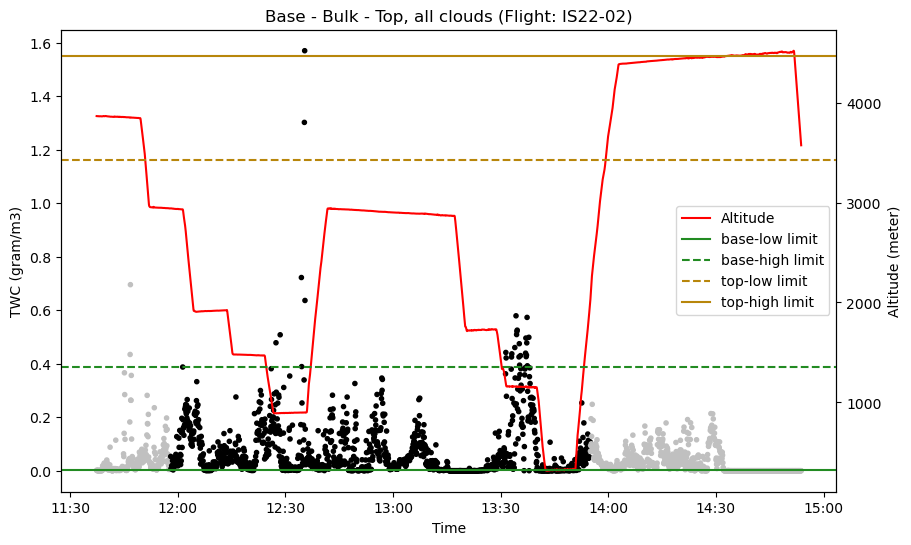

In [9]:
# --- Plotting the heights for testing
# Plotting points where the mean is calculated based on the above selection
#flight = input("State a flightid:")
flight='IS22-02'
sel_df = microphy_df[microphy_df['flightid']==flight] # filtrate on flight

var = 'TWC (gram/m3)' # variable to show with altitude

fig, ax1 = plt.subplots(nrows = 1, ncols=1, figsize=(10,6))

# plot Total Water Content
ax1.scatter(sel_df['time'], sel_df[var], marker = '.',color=np.where(sel_df['Relevance']=='Lower clouds, relevant', 'black','silver'))
ax1.set_ylabel('TWC (gram/m3)')
ax1.set_xlabel('Time')
ax1.xaxis.set_major_formatter(formatter)
ax1.set_title(f'Base - Bulk - Top, all clouds (Flight: {flight})')

#'''
ax2 = ax1.twinx()

# Plot altitude of fligth
ax2.plot(sel_df['time'], sel_df['Altitude (meter)'], 'r', label='Altitude')
ax2.set_ylabel('Altitude (meter)')
#'''

# Mark cloud position lines 
cloud_pos_dict = cloud_alt_pos(sel_df,'flightid') # get positions from function
plt.axhline(cloud_pos_dict[flight]['min'], c='forestgreen', linestyle='-', label='base-low limit')
plt.axhline(cloud_pos_dict[flight]['low_25'], c='forestgreen', linestyle='--',label='base-high limit')
plt.axhline(cloud_pos_dict[flight]['high_25'], c='darkgoldenrod', linestyle='--',label='top-low limit')
plt.axhline(cloud_pos_dict[flight]['max'], c='darkgoldenrod', linestyle='-', label='top-high limit')

plt.legend()
#plt.savefig('as220015_pointsIncloud.png')
plt.show()

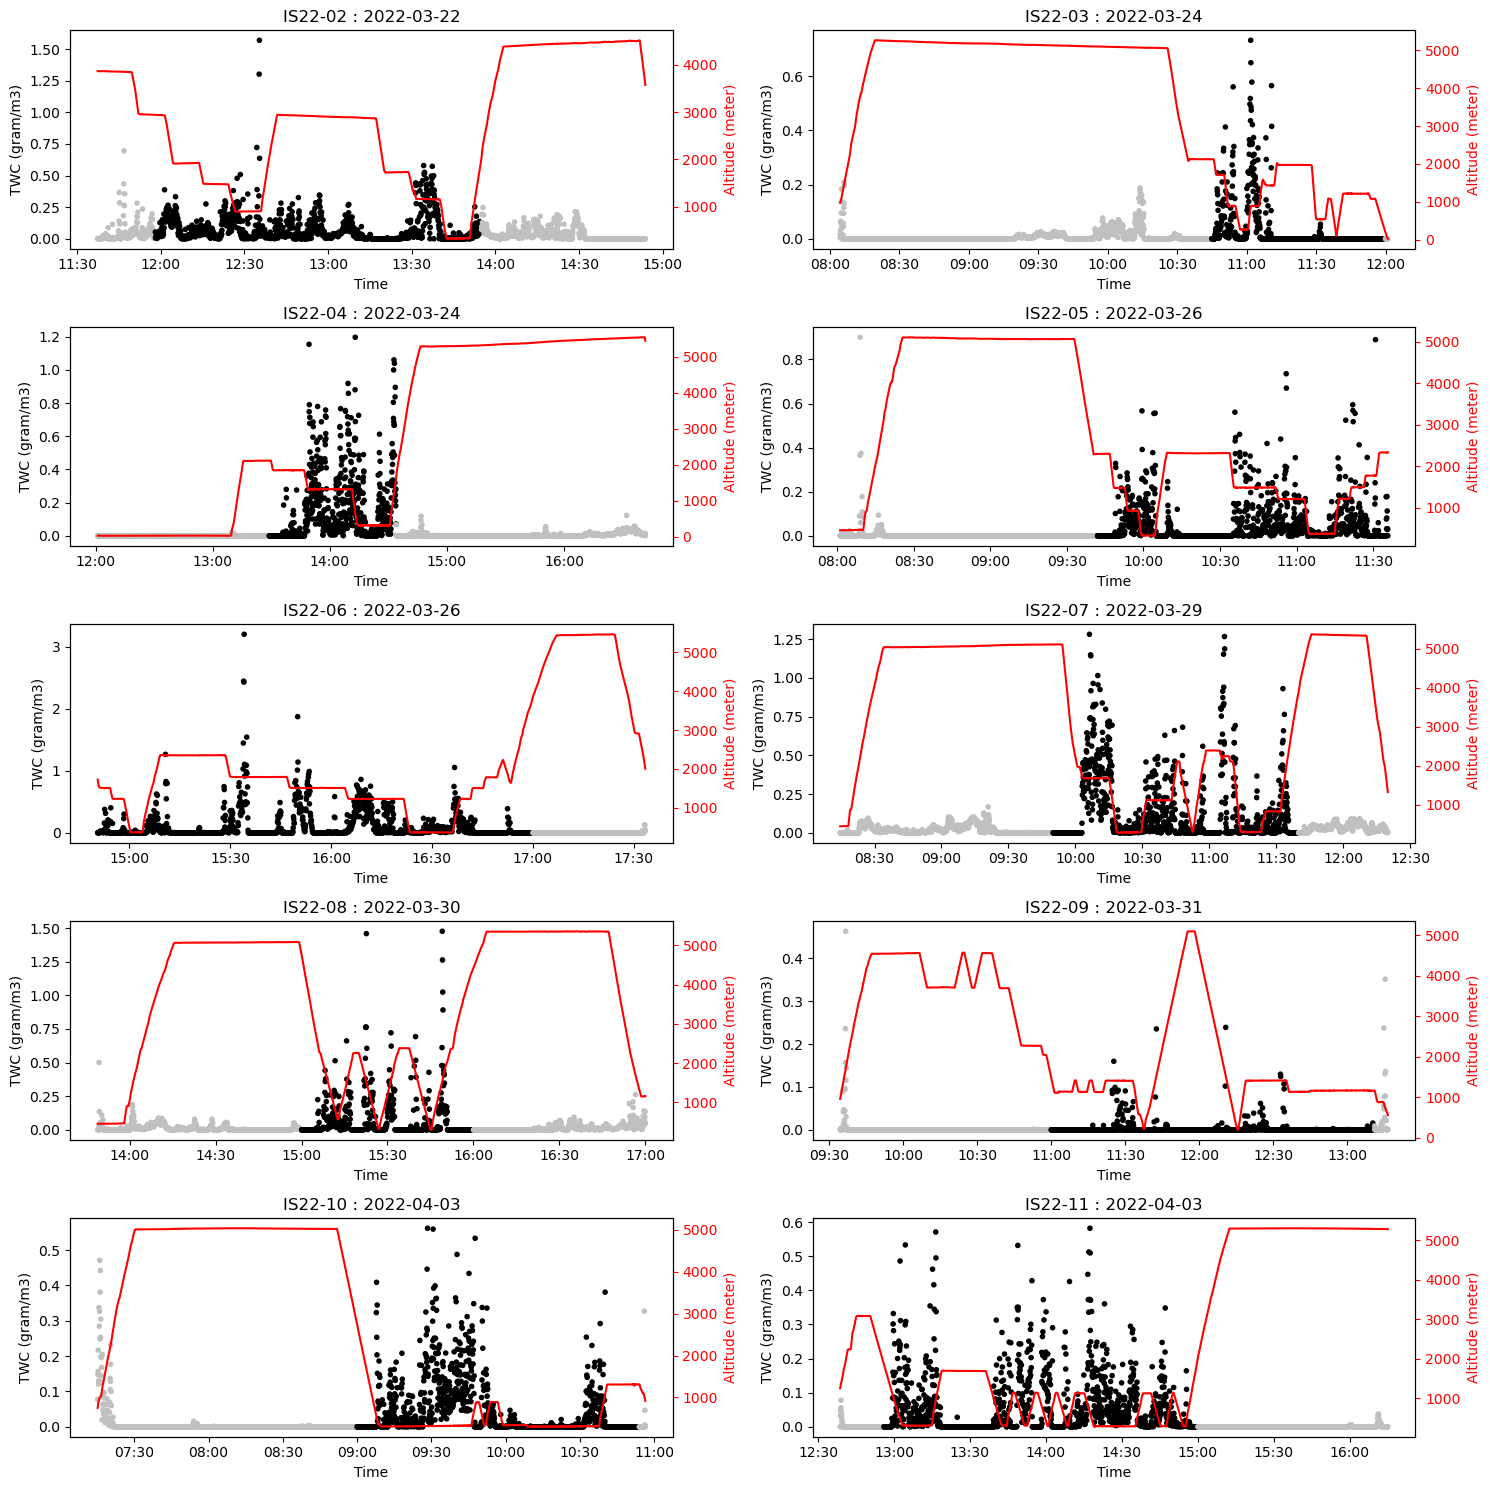

In [10]:
# ---- PLOT ALL FLIGHTS IN ONE FIGURE ----
# Create subplot grid based on the number of unique values to be plotted
num_plots = len(microphy_df['flightid'].unique())

# define number of cols and rows

# -- as close to square grid as possible
# cols = int(num_plots**0.5) # columns are the integer of the square root of the total number

# if num_plots % cols !=0: # if the remainder is not 0
#    rows = cols + 1 
# else:
#    rows = cols
# --

# -- Two columns and the needed number of rows
cols = 2
rows = int(num_plots/cols)

if num_plots % cols !=0: # add a row if num_plots not dividable with 2
    rows = row + 1 
#--

# Create a Position index needed for placing each plot correcly
position = range(1,num_plots + 1)

# Create main figure
fig = plt.figure(1, figsize=(15,15))

var = 'TWC (gram/m3)' # variable to show with altitude

for k in range(num_plots): # add every single subplot to the figure with a for loop
    flight = microphy_df['flightid'].unique()[k] #get flightid
    sel_df = microphy_df[microphy_df['flightid']==flight] # filtrate on flight
    date = sel_df.iloc[0]['time'].date() # get the date of the flight
    
    ax = fig.add_subplot(rows,cols,position[k])
    ax.set_title(f'{flight} : {date}')

    # plot variable
    ax.scatter(sel_df['time'], sel_df[var], marker = '.',color=np.where(sel_df['Relevance']=='Lower clouds, relevant', 'black','silver'))
    ax.set_ylabel(var)
    ax.set_xlabel('Time')
    
    # add second y-axis
    ax2 = ax.twinx()
    
    # Plot altitude of flight (in color green)    
    ax2.plot(sel_df['time'], sel_df['Altitude (meter)'], 'r', label='Altitude')
    ax2.set_ylabel('Altitude (meter)')
    ax2.yaxis.label.set_color('r')
    ax2.tick_params(axis='y', colors = 'r')
    ax.xaxis.set_major_formatter(formatter) # only show time on x-axis

fig.tight_layout() # get a better distance between figures.
plt.savefig('img_islas_definelowerclouds.png')
plt.show()


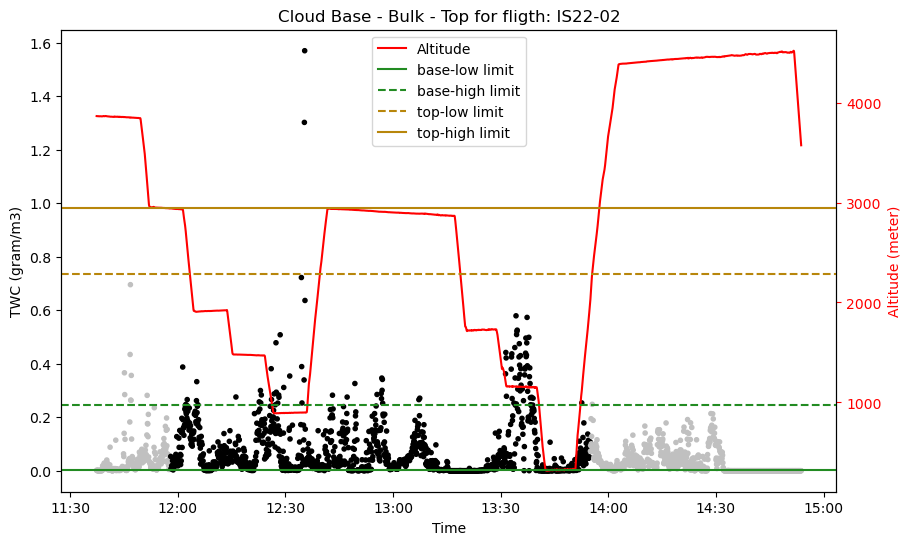

In [11]:
# --- Plotting the heights for testing after separating out high clouds
# Plotting points where the mean is calculated based on the above selection
#flight = input("State a flightid:")
flight='IS22-02'
sel_df = microphy_df[microphy_df['flightid']==flight] # filtrate on flight
#lines = sel_df[sel_df['InCloudTimeStep'] == True] # filtrate on incloud time steps (for plotting vertical lines)

fig, ax1 = plt.subplots(nrows = 1, ncols=1, figsize=(10,6))

# plot Total Water Content
ax1.scatter(sel_df['time'], sel_df[var], marker = '.',color=np.where(sel_df['Relevance']=='Lower clouds, relevant', 'black','silver'))
ax1.set_ylabel('TWC (gram/m3)')
ax1.set_xlabel('Time')
ax1.xaxis.set_major_formatter(formatter)
ax1.set_title(f'Cloud Base - Bulk - Top for fligth: {flight}')

#'''
ax2 = ax1.twinx()

# Plot altitude of fligth
ax2.plot(sel_df['time'], sel_df['Altitude (meter)'], 'r', label='Altitude')
ax2.set_ylabel('Altitude (meter)')
ax2.yaxis.label.set_color('r')
ax2.tick_params(axis='y', colors = 'r')
#'''

# Mark cloud position lines, based on the relevant clouds
rel_height_df = sel_df[sel_df['Relevance']=='Lower clouds, relevant'] # filtrate relevant lower clouds
cloud_pos_dict = cloud_alt_pos(rel_height_df,'flightid') # get positions from function
plt.axhline(cloud_pos_dict[flight]['min'], c='forestgreen', linestyle='-', label='base-low limit')
plt.axhline(cloud_pos_dict[flight]['low_25'], c='forestgreen', linestyle='--',label='base-high limit')
plt.axhline(cloud_pos_dict[flight]['high_25'], c='darkgoldenrod', linestyle='--',label='top-low limit')
plt.axhline(cloud_pos_dict[flight]['max'], c='darkgoldenrod', linestyle='-', label='top-high limit')

plt.legend()
#plt.savefig('as220015_pointsIncloud.png')
plt.show()

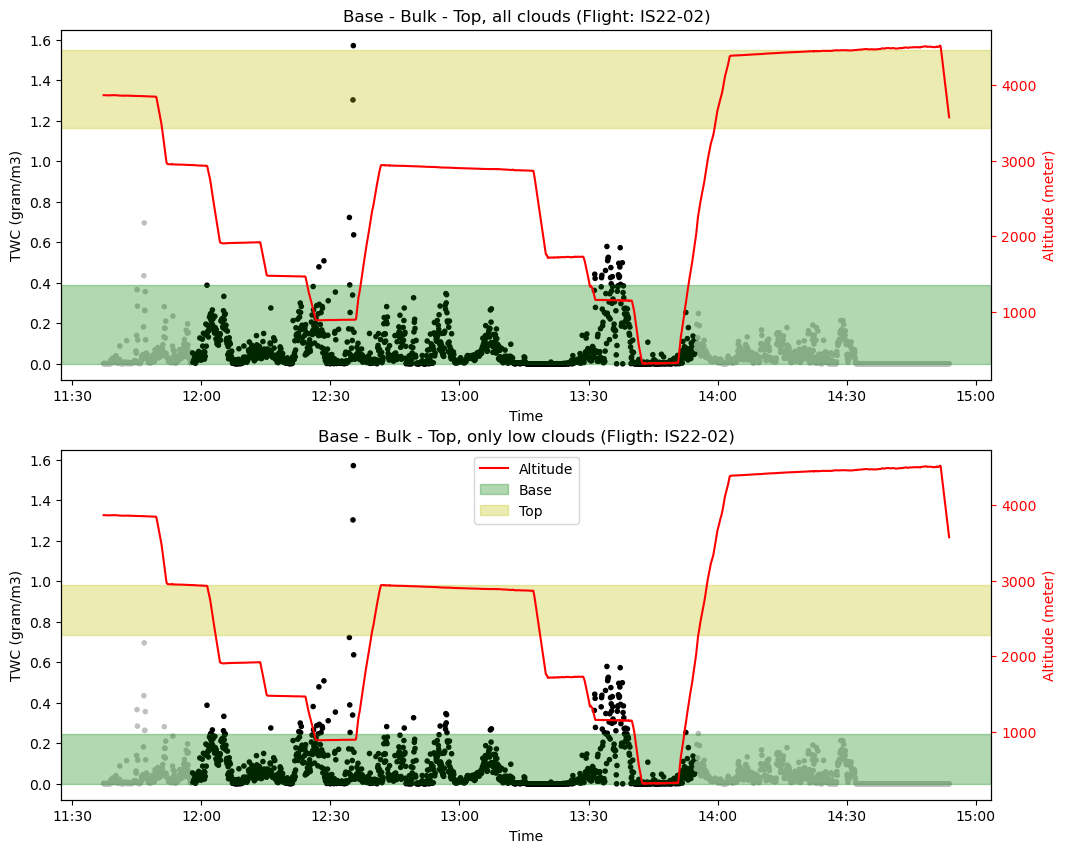

In [12]:
# --- Plotting the heights for testing
# Plotting points where the mean is calculated based on the above selection
#flight = input("State a flightid:")
flight='IS22-02'
sel_df = microphy_df[microphy_df['flightid']==flight] # filtrate on flight

var = 'TWC (gram/m3)' # variable to show with altitude

fig, axes = plt.subplots(nrows = 2, ncols=1, figsize=(12,10))

# 1st plot
axes[0].scatter(sel_df['time'], sel_df[var], marker = '.',color=np.where(sel_df['Relevance']=='Lower clouds, relevant', 'black','silver'))
axes[0].set_ylabel('TWC (gram/m3)')
axes[0].set_xlabel('Time')
axes[0].xaxis.set_major_formatter(formatter)
axes[0].set_title(f'Base - Bulk - Top, all clouds (Flight: {flight})')

#'''
ax2 = axes[0].twinx()

# Plot altitude of fligth
ax2.plot(sel_df['time'], sel_df['Altitude (meter)'], 'r', label='Altitude')
ax2.set_ylabel('Altitude (meter)')
ax2.yaxis.label.set_color('r')
ax2.tick_params(axis='y', colors = 'r')
#'''

# 2nd plot
axes[1].scatter(sel_df['time'], sel_df[var], marker = '.',color=np.where(sel_df['Relevance']=='Lower clouds, relevant', 'black','silver'))
axes[1].set_ylabel('TWC (gram/m3)')
axes[1].set_xlabel('Time')
axes[1].xaxis.set_major_formatter(formatter)
axes[1].set_title(f'Base - Bulk - Top, only low clouds (Fligth: {flight})')

#'''
ax3 = axes[1].twinx()

# Plot altitude of fligth
ax3.plot(sel_df['time'], sel_df['Altitude (meter)'], 'r', label='Altitude')
ax3.set_ylabel('Altitude (meter)')
ax3.yaxis.label.set_color('r')
ax3.tick_params(axis='y', colors = 'r')
#'''

# Mark cloud position lines 
total_pos_dict = cloud_alt_pos(sel_df,'flightid') # get positions when all clouds are considered

rel_height_df = sel_df[sel_df['Relevance']=='Lower clouds, relevant'] # filtrate relevant lower clouds
low_pos_dict = cloud_alt_pos(rel_height_df,'flightid') # get positions when only low clouds are considered

# all clouds
ax2.axhspan(ymin = total_pos_dict[flight]['min'], ymax = total_pos_dict[flight]['low_25'], color = 'g', alpha = 0.3, label ='Base')
ax2.axhspan(ymin = total_pos_dict[flight]['high_25'], ymax = total_pos_dict[flight]['max'], color = 'y', alpha = 0.3, label ='Top')
# only low clouds
ax3.axhspan(ymin = low_pos_dict[flight]['min'], ymax = low_pos_dict[flight]['low_25'], color = 'g', alpha = 0.3, label ='Base')
ax3.axhspan(ymin = low_pos_dict[flight]['high_25'], ymax = low_pos_dict[flight]['max'], color = 'y', alpha = 0.3, label ='Top')


fig.tight_layout
plt.legend()
plt.savefig('example_alt_allvslow.png')
plt.show()

### Flight Information from the flight reports per flight for in/out of cloud information
Cirrus (Ci), cirrocumulus (Cc), and cirrostratus (Cs) are high level clouds.
Altocumulus (Ac), altostratus (As), and nimbostratus (Ns)
Cumulus (Cu), stratocumulus (Sc), stratus (St), and cumulonimbus (Cb)

#### IS22-02
To layers of clouds, top of lower one at approx 3860m at beginning and 2300m at end, base at approx 320 m
in and out of lower cloud:
in: 2022-03-22T11:58:28.7Z
out:2022-03-22T13:55:36.9Z

#### IS22-03
- small cloud at first ascend
- ice cloud in upper level (between 0900 and 1030)
- leg-start into lower level clouds: 2022-03-24T10:46:53.3Z
- Stops at Longyearbyen

#### IS22-04
- takeoff from longyearbyen
- first cloud descent: 2022-03-24T13:29:51.8Z
- cloud out at "final" ascent: 2022-03-24T14:34:09.2Z

#### IS22-05
- some clouds at initial ascent
- first leg start at 0942 (2300 m) just above cloud top
- same cloudlevel to end.

#### IS22-06
1st. leg start at 1451
several maneuvers 
out of last cloud at 17:00

#### IS22-07
Going into altostratuslayer at first ascent.
Descent start into lower clouds at 0953 (Cu Sc)
lots of icing
1131: begin of final ascent. (stop when reaching 200 m?)

#### IS22-08
Cloud in right after takeoff (14:00)
decend and enter cloud (Cu): 15
sawtooth pattern
final ascent end: 1600
clouds at ending, probabli the altostratus and cumulus mentioned in the flight report. skip these

#### IS22-09
Entering Sc right in takeoff
clouds after 11
top of clouds 11:50
entering top of clouds again 12:09 (no clouds in between)
leg stop at 1300

#### IS22-10
cloud in right after takeoff (if included stop at 0730) Cu
0900: entering Sc
fog/seaice below)
1030: Cu/Sc
End at clim stop: 1042

#### IS22-11
from start to 15 rlevant lower clouds, after 15 uninteerestinng


In [13]:
sel_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cdp MVD (um)', 'Cloud_pos',
       'Relevance', 'cip NumConc (#/cm^3)', 'tot NumConc (#/cm3)',
       'TWC (gram/m3)', 'incloud'],
      dtype='object')

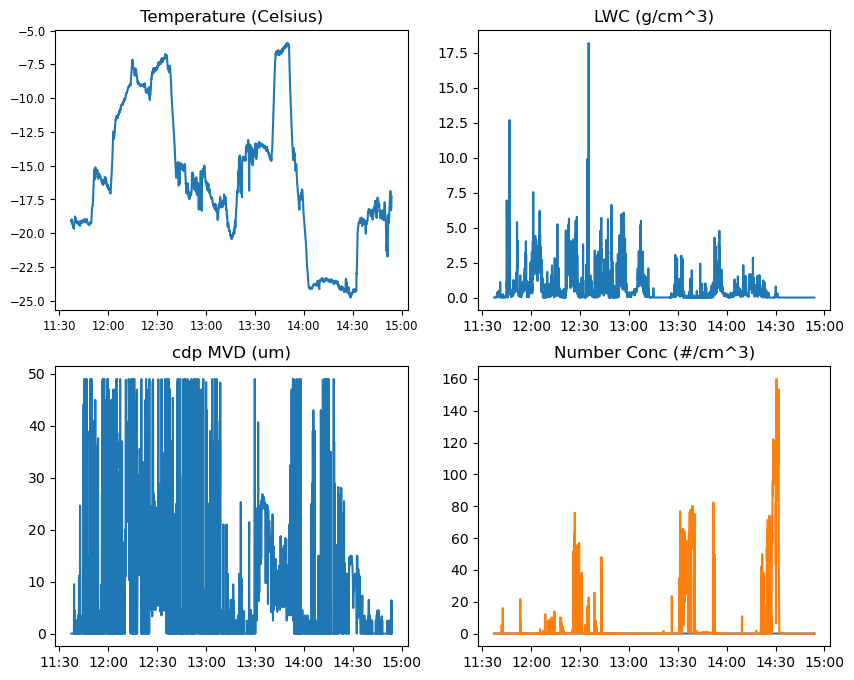

In [14]:
# --- Plotting ---


fig, axs = plt.subplots(2,2, figsize=(10,8))

# plot temperature against time
axs[0,0].plot(sel_df['time'], sel_df['Temperature (Celsius)'])
axs[0,0].set_title('Temperature (Celsius)')
# rotate x-axis labels
#axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[0,0].tick_params(labelsize='small')
axs[0,0].xaxis.set_major_formatter(formatter)

axs[0,1].plot(sel_df['time'], sel_df['cip LWC (g/m^3)'], label = 'CIP')
axs[0,1].set_title('LWC (g/cm^3)')
#axs[0,1].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[0,1].xaxis.set_major_formatter(formatter)

axs[1,1].plot(sel_df['time'], sel_df['cip NumConc (#/cm^3)'], label = 'CIP')
axs[1,1].plot(sel_df['time'], sel_df['cdp NumConc corr (#/cm^3)'], label = 'CDP')
axs[1,1].set_title('Number Conc (#/cm^3)')
#axs[1,1].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[1,1].xaxis.set_major_formatter(formatter)

axs[1,0].plot(sel_df['time'], sel_df['cdp MVD (um)'])
axs[1,0].set_title('cdp MVD (um)')
#axs[1,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=45)
axs[1,0].xaxis.set_major_formatter(formatter)

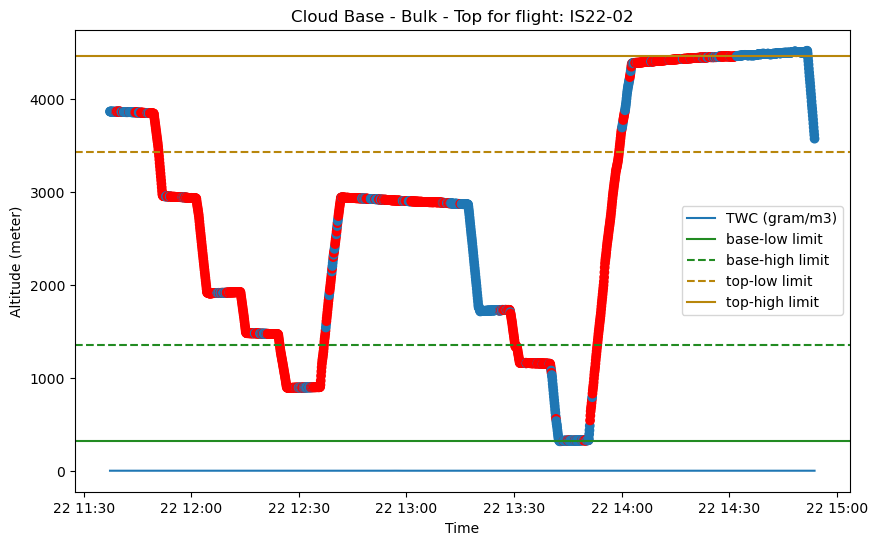

In [15]:
# --- Plotting the heights for testing
# coloring based on definesd as in cloud or not
#flight = input("State a flightid:")
flight='IS22-02'
sel_df = microphy_df[microphy_df['flightid']==flight] # filtrate on flight

fig, ax1 = plt.subplots(nrows = 1, ncols=1, figsize=(10,6))

# plot Total Water Content

plt.scatter(sel_df['time'], sel_df['Altitude (meter)'], 
            color=np.where(sel_df['incloud'], 'r','C0')
           )
ax1.plot(sel_df['time'], sel_df['TWC (gram/m3)'], label = 'TWC (gram/m3)')
ax1.set_ylabel('Altitude (meter)')
ax1.set_xlabel('Time')
ax1.set_title(f'Cloud Base - Bulk - Top for flight: {flight}')


# Mark cloud position lines 
cloud_pos_dict = cloud_alt_pos(sel_df,'flightid') # get positions from function
plt.axhline(cloud_pos_dict[flight]['min'], c='forestgreen', linestyle='-', label='base-low limit')
plt.axhline(cloud_pos_dict[flight]['low_25'], c='forestgreen', linestyle='--',label='base-high limit')
plt.axhline(cloud_pos_dict[flight]['high_25'], c='darkgoldenrod', linestyle='--',label='top-low limit')
plt.axhline(cloud_pos_dict[flight]['max'], c='darkgoldenrod', linestyle='-', label='top-high limit')

plt.legend()
#plt.savefig('as220015_pointsIncloud.png')
plt.show()

In [16]:
# -----ROLLING MEAN VERSION, skip this
# calculate the rolling mean of TWC over X timesteps
# I am interested in 2 min legs of the cloud: each timestep is 5 sec -> rolling window of 24 will be 2 min
#leg_min = 2
#w = int(leg_min*(60/5)) # needs to be an integer

# rolling mean also calculated for LWC and Temperature
#microphy_df['TWC_RM'] = microphy_df['TWC (gram/m3)'].rolling(window=w, center = True).mean()
#microphy_df['LWC_RM'] = microphy_df['cdp LWC corr (g/m^3)'].rolling(window=w, center = True).mean()
#microphy_df['T_RM'] = microphy_df['Temperature (Celsius)'].rolling(window=w, center = True).mean()

In [17]:
# -- Temperature bin adjustment
# set min, max and interval for temperature bins
t_int = 2 # the interval I want my bins to be in (in whole degrees)

#--- temperature bins set on interesting range
tb_min = -40
tb_max = 0
# --------

b_range = np.arange(tb_min, tb_max, t_int) # create bin range
b_labels = np.arange((tb_min+t_int), tb_max, t_int) # create bin labels, use higher bounds
#b_labels = np.arange(tb_min, tb_max-t_int, t_int) # create bin labels, use lower bounds

# add new column to microphy dataframe with temperature category based on: 
microphy_df['temp_cat'] = pd.cut(microphy_df['Temperature (Celsius)'], bins=b_range, labels=b_labels) # temperature
#microphy_df['temp_cat'] = pd.cut(microphy_df['T_RM'], bins=b_range, labels=b_labels) #the rolling mean temperature


In [18]:
# --- Calculate mean leg length in cloud
# Skip this when not doing legs
#c_tas_m = microphy_df[microphy_df['TWC (gram/m3)']>in_cl_th]['TAS (m/s)'].mean() # mean of TAS in cloud (calculated where TWC > threshold)
                                                                             # 104.725 m/s
# calculating leg length
#print(f'Currently a leg length of {leg_min} min is used')
#print(f'With leg length of 0.5 min, distance traveled is {int(c_tas_m*0.5*60)} m')
#print(f'With leg length of 1 min, distance traveled is {int(c_tas_m*1*60)} m')
#print(f'With leg length of 2 min, distance traveled is {int(c_tas_m*2*60)} m')
#print(f'With leg length of 5 min, distance traveled is {int(c_tas_m*5*60)} m')
#print(f'To get a leg length of approximately 1 km, leg_min must equal {round(1000/(c_tas_m*60),3)} min')


### Building a function that averages over given time-frames
This function should take a dataframe and average all numerical columns over the number of minutes given.
Should also:
- separate based on categorical value (like flightd)


Rolling average could be useful for deciding in-cloud values:
df['Rolling average center'] = df['variable'].rolling(window=5, center = True).mean()
center: if true, the rolling window is based on values before and after the given point. 
window: the number of consecutive items in the variable to calculate the mean.

In [19]:
# ---- SKIP THIS! Only relevant when using rolling averages over legs of cloud
# Selecting In-Cloud timesteps equally spaced over the cloud (according to leg_min)
# For plotting mean values

#microphy_df['InCloudTimeStep'] = False # initiate new column of micropy
#new = 0 # boolean: in or out of cloud.

# Logic for choosing indexes where TWC_RM is bigger than threshold
#for idx, val in enumerate(microphy_df['TWC_RM']):         # go through all timesteps in microphy

 #   if val > in_cl_th:                                    # if the val is bigger than threshold
 #       if new == 0:                                      # and if cloud boolean is 0 (outside of cloud)
 #           microphy_df.loc[idx,'InCloudTimeStep']=True # add index to list of indexes
 #           time = microphy_df['time'].iloc[idx]          # get the time of this entry (since this is the first index of a cloud)
 #           new = 1                                       # Update boolean to inside of cloud
 #       else:                                             # else if new=1 (inside of cloud)
 #           new_time = microphy_df['time'].iloc[idx]      # get the time for this idx
 #           time_diff = (new_time-time).total_seconds()   # get time difference from entering cloud in seconds
 #           if time_diff < (leg_min*60):                  # if time difference less than the leg_min: 
 #               continue                                  # go to next timestep
 #           else:                                         # else if time difference is equal to or more than the leg_min
 #               microphy_df.loc[idx,'InCloudTimeStep']=True   # add this index to the list of indexes
 #               time = microphy_df['time'].iloc[idx]      # get the time of this entry to compare with next timestep
 #   else:                                                 # else if the val is not bigger than the threshold
 #       if new == 0:                                      # we are not in a cloud yet
 #           continue                                      # go to next timestep
 #       else:                                             # else if new = 1: in cloud at last timestep
 #           new = 0                                       # Set boolean to outside of cloud

#print(microphy_df[microphy_df['InCloudTimeStep']==True])
#microphy_df.head()



In [20]:
# ---- SKIP THIS! Only relevant when using rolling averages over legs of cloud
# Plotting points where the mean is calculated based on the above selection
#flight = input("State a flightid:")
#flight='IS22-02'
#sel_df = microphy_df[microphy_df['flightid']==flight] # filtrate on flight
#lines = sel_df[sel_df['InCloudTimeStep'] == True] # filtrate on incloud time steps (for plotting vertical lines)#

#fig, ax1 = plt.subplots(nrows = 1, ncols=1, figsize=(10,6))

# plot Total Water Content
#ax1.plot(sel_df['time'], sel_df['TWC_RM'], label = 'TCM 2-min rolling mean')
#ax1.set_ylabel('TWC (gram/m3)')
#ax1.set_xlabel('Time')
#ax1.set_title(f'Points where the {leg_min}-min in cloud mean \n is calculated for flight:{flight}')

#'''
#ax2 = ax1.twinx()

# Plot altitude of fligth
#ax2.plot(sel_df['time'], sel_df['Altitude (meter)'], 'r', label='Altitude')
#ax2.set_ylabel('Altitude (meter)')
#'''

# Mark in-cloud values 

#for time in lines['time']:
#    plt.axvline(x=time, color='g', linestyle='--')


#plt.legend()
#plt.savefig('as220015_pointsIncloud.png')
#plt.show()

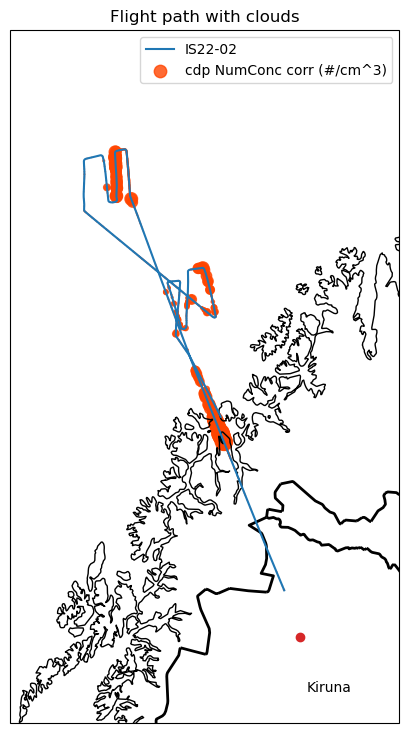

In [21]:
# Plot location for flight, plotting via predefined function

# need to get safireid from
# functions.plot_flight_v_data(flight, nav_stats_dict, microphy_df)
functions.plot_flight_v_data(flight, sel_df, variable='cdp NumConc corr (#/cm^3)')

## super cooled liquid fraction

From komurcu 2014: SLF = r(liquid water)/(r(liquid water) + r(ice))
where r= mixing ration in kg/kg

I have LWC from cdp and iwc from cip instead: 

In [22]:
# SKIP THIS Rolling mean
# Version 3 (Rolling mean calculated at indexes selected
# -- Calculate SLF (supercooled liquid fraction)

# index_l: selected indexes based on the logic above

# Creating a copy of the dataframe where only the rolling average in-cloud values are selected
# (in_cloud_df is defined above)
#sel_cp_df = microphy_df[microphy_df['InCloudTimeStep'] == True].copy()

# calculate SLF by dividing LWC with TWC (using the rolling mean values)
#sel_cp_df['SLF_RM']= sel_cp_df['LWC_RM']/microphy_df['TWC_RM']*100

# categorize cloud phase
# set up categories for phase determination
# list of conditions to select categories
#SLF_conds = [
#    (sel_cp_df['SLF_RM'] <= 0.1),
#    (sel_cp_df['SLF_RM'] >= 0.9),
#    (sel_cp_df['SLF_RM'] > 0.1) & (sel_cp_df['SLF_RM'] < 0.9)

# list of categories to return
#phase = [
#    'ice',
#    'liquid',
#    'mixed-phase'
#]
#sel_cp_df['cloud_phase_RM']=np.select(SLF_conds,phase,"ERROR")


In [27]:
# Version 4: calculate SLF (on base values)
# -- Calculate SLF (supercooled liquid fraction)

# calculate SLF by dividing LWC with TWC (using the rolling mean values)
microphy_df['SLF']= np.where(microphy_df['incloud']==True, microphy_df['cdp LWC corr (g/m^3)']/microphy_df['TWC (gram/m3)']*100, np.nan)

# categorize cloud phase
# set up categories for phase determination
# list of conditions to select categories
SLF_conds = [
    (microphy_df['SLF'] <= 0.1),
    (microphy_df['SLF'] >= 0.9),
    (microphy_df['SLF'] > 0.1) & (microphy_df['SLF'] < 0.9)
]
# list of categories to return
phase = [
    'ice',
    'liquid',
    'mixed-phase'
]
microphy_df['cloud_phase']=np.select(SLF_conds,phase,"ERROR")

In [33]:
microphy_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cdp MVD (um)', 'Cloud_pos',
       'Relevance', 'cip NumConc (#/cm^3)', 'tot NumConc (#/cm3)',
       'TWC (gram/m3)', 'incloud', 'temp_cat', 'SLF', 'cloud_phase'],
      dtype='object')

In [30]:
# define colors for different types of separation
#colors= {'as220008':'tab:orange', 
#                 'as220009':'tab:green',
#                 'as220010':'tab:red',
#                 'as220011':'tab:purple', 
#                 'as220012':'tab:brown', 
#                 'as220013':'tab:pink',
#                'as220014':'tab:olive',
#                 'as220015':'tab:cyan'}  
colors = {'IS22-01':'wheat',
          'IS22-02':'tab:green',
          'IS22-03':'tab:red',
          'IS22-04':'tab:purple',
          'IS22-05':'tab:blue',
          'IS22-06':'tab:brown',
          'IS22-07':'tab:gray',
          'IS22-08':'tab:olive',
          'IS22-09':'tab:cyan',
          'IS22-10':'tab:pink',
          'IS22-11':'tab:orange'
         }
var='flightid'
microphy_df[var].map(colors)

0         tab:green
1         tab:green
2         tab:green
3         tab:green
4         tab:green
            ...    
26249    tab:orange
26250    tab:orange
26251    tab:orange
26252    tab:orange
26253    tab:orange
Name: flightid, Length: 26254, dtype: category
Categories (10, object): ['tab:green', 'tab:red', 'tab:purple', 'tab:blue', ..., 'tab:olive', 'tab:cyan', 'tab:pink', 'tab:orange']

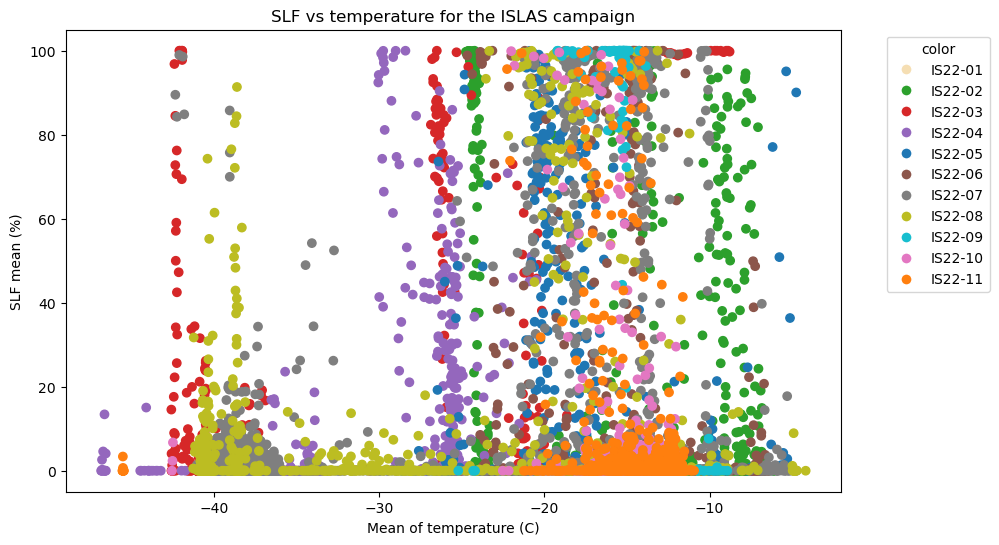

In [34]:
# plot slf against temperature

def plot_slf_leg(df, flight="", save_f=""):
    #plot_slf_leg(df, leg_min, flight="", save_f="")
    # Plots the SLF vs temperature. 
    # 
    # Input: 
    # df: dataframe that includes the SLF and Temperature data to be plotted
    # leg_min: # of minutes the data is averaged over, for titles in plot REMOVED FOR NOW
    # flight: Optional parameter for titles in plot, when exluded it is assumed that the full dataset is used
    # save_f: optional filename to save figure to
    
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.lines import Line2D  # for legend handle

    
    # TODO: test if df has the needed columns, return error message if not
    # TODO: use input to change what it separates colors on

    # set title and legend based on what is given in flight (nothing equals full dataset
    if flight == "":
        title = f'SLF vs temperature for the ISLAS campaign'
        l = 'ISLAS'
    else:
        title = f'SLF vs temperature for flight:{flight}'
        l = flight

    # define colors for different types of separation
    c_flights = {'IS22-01':'wheat',
          'IS22-02':'tab:green',
          'IS22-03':'tab:red',
          'IS22-04':'tab:purple',
          'IS22-05':'tab:blue',
          'IS22-06':'tab:brown',
          'IS22-07':'tab:gray',
          'IS22-08':'tab:olive',
          'IS22-09':'tab:cyan',
          'IS22-10':'tab:pink',
          'IS22-11':'tab:orange'}  
    c_surface = {'land-main':'tab:blue', 'sea-ocean':'tab:orange', 'sea-ice':'tab:green'}
    c_area = {'cloud-top':'tab:blue', 'cloud-bulk':'tab:orange', 'cloud-base':'tab:green'}

    colors = c_flights
    var = 'flightid'

    

    # ---- Plot SLF vs Temp -----
    fig, ax1 = plt.subplots(nrows = 1, ncols=1, figsize=(10,6))

    ax1.scatter(df['Temperature (Celsius)'], df['SLF'], c=df[var].map(colors))

    # Plot best fit line based on separation
    

    # Plot decorations
    ax1.set_ylabel(f'SLF (%)')
    ax1.set_xlabel(f'Temperature (C)')
    ax1.set_title(title)
    # Legend
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
    ax1.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    # save figure if filename is given
    if save_f != "":
        # save figure in the Figures folder for presentations if filename is given
        plt.savefig(f'Figures/{save_f}', bbox_inches='tight')

    plt.show()

plot_slf_leg(microphy_df, save_f='SLF_obs.png')


## Steps for creating the CDF

- Calculate a histogram
- Find the PDF (probability density function) from the histogram
- Calculate the CDF from the PDF (The CDF is the integral of the PDF

Calculate the probablity density function. PDF is for continous variables, PMF (probability mass function) is for discrete values. SLF and temperature both are continuous. 
The cumuluative is the probability of the value or less (the sum of the ares on the left hand side.


In [ ]:
# plot the histogram of the data:
import pandas as pd
import matplotlib.pyplot as plt

# Example data
data = {'TemperatureBin': ['0-2', '2-4', '4-6', '6-8', '8-10'],
        'SLF': [10, 20, 30, 40, 50]}

df = pd.DataFrame(data)

# Convert the 'TemperatureBin' column to a categorical type for proper ordering
df['TemperatureBin'] = pd.Categorical(df['TemperatureBin'], 
                                      categories=df['TemperatureBin'].unique(), 
                                      ordered=True)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(df['TemperatureBin'], df['SLF'], color='skyblue')
plt.xlabel('Temperature bins (°C)')
plt.ylabel('SLF (%)')
plt.title('SLF vs Temperature bins')
plt.xticks(rotation=45)
plt.show()


In [47]:
# Example data
data = {'TemperatureBin': ['0-2', '2-4', '4-6', '6-8', '8-10'],
        'SLF': [10, 20, 30, 40, 50]}

df = pd.DataFrame(data)

# To demonstrate on larger scale, create more records for each bin
import numpy as np
np.random.seed(0)  # For reproducibility
temperature_bins = np.repeat(df['TemperatureBin'], [50, 40, 30, 20, 10])
slf_values = np.random.normal(loc=np.array(df['SLF']), scale=5, size=150)  # Generate normally distributed SLF values around the means

data_expanded = {'TemperatureBin': temperature_bins, 'SLF': slf_values}
df_expanded = pd.DataFrame(data_expanded)

# Count the number of SLF values in each temperature bin
counts = df_expanded['TemperatureBin'].value_counts().sort_index()

# Calculate the PDF (Probability Density Function)
pdf = counts / counts.sum()

# Calculate the CDF (Cumulative Distribution Function)
cdf = pdf.cumsum()

# Combine the results into a DataFrame for easier handling and plotting
results = pd.DataFrame({'Counts': counts, 'PDF': pdf, 'CDF': cdf})

print(results)

# Plot the PDF and CDF
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(df['TemperatureBin'], results['PDF'], color='skyblue', alpha=0.7, edgecolor='blue', label='PDF')
ax1.set_xlabel('Temperature bins (°C)')
ax1.set_ylabel('PDF', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df['TemperatureBin'], results['CDF'], color='darkred', marker='o', label='CDF')
ax2.set_ylabel('CDF', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

.title('PDF and CDF of SLF values over Temperature bins')
fig.tight_layout()
plt.show()

TypeError: 'Index' object is not callable

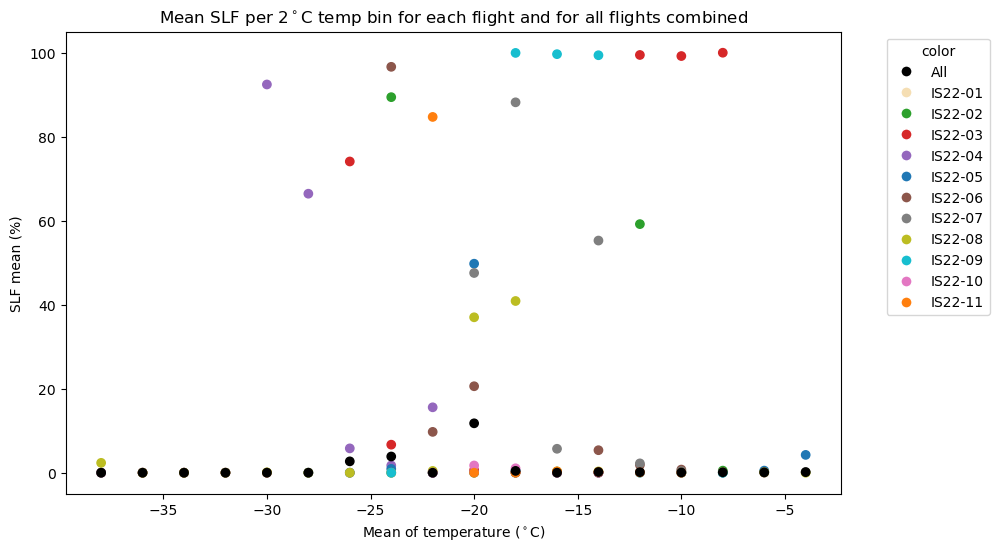

In [47]:
# --- median value SLF for the given temperature categories and plot as for all values
# calculate the median of variables per temperature category and store in dictionary

def med_per_temp_cat(df, var, temp_cat_ref, flightid):
    # df: dataframe to use
    # var: variable to do the mean over (string)
    # temp_cat_ref: "Empty" dataframe with the temp categories to use. (to get NaN where no values)
    # flightid: flightid of the dataset calculated (flightid or all for the full set)

    # calculate median per temperature category
    var_med_per_cat = df.groupby(['temp_cat'], observed=True)[var].median()
    # combine temp_cat_ref with calculated median per temp. cat., gives NaN on temp categories not present
    result = pd.merge(temp_cat_ref, var_med_per_cat, on='temp_cat', how='left')
    result['flightid']= flightid

    return result

ref_df = pd.DataFrame({'temp_cat': list(b_labels)}) #create empty reference dataset (to get NaN where no values)
all_df = med_per_temp_cat(microphy_df, 'SLF', ref_df, 'All') # median per temp cat for all flights combined


# create list with median per temp cat per flight
med_flight_list = [med_per_temp_cat(microphy_df[microphy_df['flightid']==flight],'SLF',ref_df,flight) for flight in flights]
med_flight_list.append(all_df) # add the values for all flights combined
med_per_temp_cat_df = pd.concat(med_flight_list) # turn into dataframe

# plot 
# define colors for different types of separation
c_flights = {'All':'k','IS22-01':'wheat',
          'IS22-02':'tab:green',
          'IS22-03':'tab:red',
          'IS22-04':'tab:purple',
          'IS22-05':'tab:blue',
          'IS22-06':'tab:brown',
          'IS22-07':'tab:gray',
          'IS22-08':'tab:olive',
          'IS22-09':'tab:cyan',
          'IS22-10':'tab:pink',
          'IS22-11':'tab:orange'}

# ---- Plot SLF vs Temp -----
from matplotlib.lines import Line2D  # for legend handle

# Plot V1: scatterplot
fig, ax1 = plt.subplots(nrows = 1, ncols=1, figsize=(10,6))

ax1.scatter(med_per_temp_cat_df['temp_cat'], med_per_temp_cat_df['SLF'], c = med_per_temp_cat_df['flightid'].map(c_flights))

# Plot best fit line based on separation


# Plot decorations
ax1.set_ylabel(f'SLF mean (%)')
ax1.set_xlabel(f'Mean of temperature ($^\\circ$C)')
ax1.set_title('Mean SLF per 2$^\\circ$C temp bin for each flight and for all flights combined') #double \\ to avoid syntax warning
# Legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in c_flights.items()]
ax1.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# save figure in the Figures folder for presentations if filename is given
plt.savefig(f'Figures/SLF_scatter_temp_bins_png', bbox_inches='tight')

plt.show()

slf_temp_stat = microphy_df.groupby(['temp_cat'], observed=True)['SLF'].median()

temp_cat
-38     0.000000
-36     0.000000
-34     0.000000
-32     0.000000
-30     0.010788
-28     0.004911
-26     2.706969
-24     3.863610
-22     0.000000
-20    11.766233
-18     0.434456
-16     0.020858
-14     0.169772
-12     0.138375
-10     0.061512
-8      0.107817
-6      0.079556
-4      0.144317
-2           NaN
Name: SLF, dtype: float64


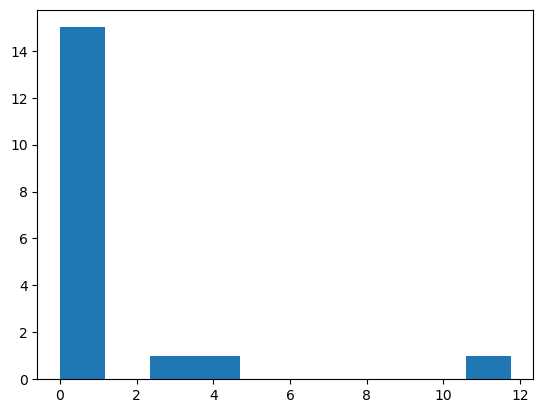

In [54]:
print(slf_temp_stat)
plt.hist(slf_temp_stat)
plt.show()

/tmp/ipykernel_10304/2176077499.py:4: RuntimeWarning: invalid value encountered in divide
  pdf = count / sum(count)


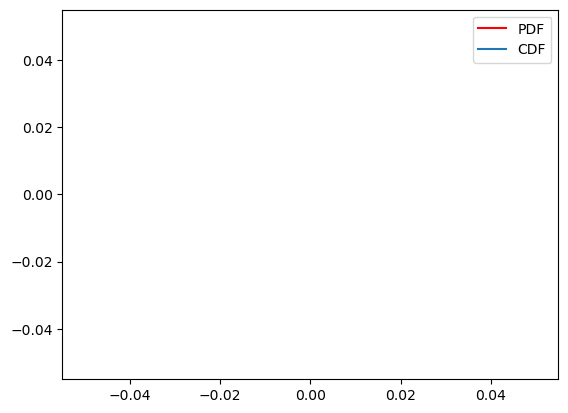

In [43]:
count, bins_count = np.histogram(all_df['SLF'], bins = all_df['temp_cat'])

# finding the PDF of the histogram using count values 
pdf = count / sum(count) 
  
# using numpy np.cumsum to calculate the CDF 
# We can also find using the PDF values by looping and adding 
cdf = np.cumsum(pdf) 
  
# plotting PDF and CDF 
plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
plt.plot(bins_count[1:], cdf, label="CDF") 
plt.legend() 

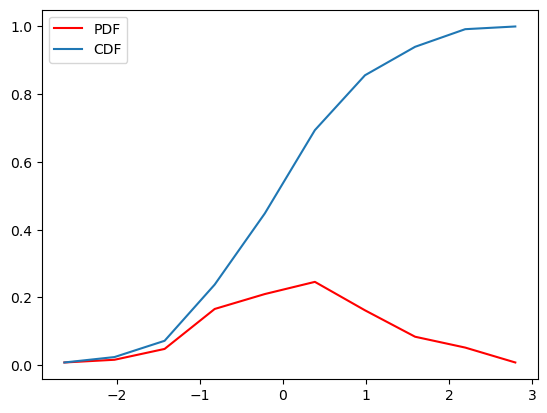

In [44]:
# defining the libraries 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline 

# No of Data points 
N = 500

# initializing random values 
data = np.random.randn(N) 

# getting data of the histogram 
count, bins_count = np.histogram(data, bins=10) 

# finding the PDF of the histogram using count values 
pdf = count / sum(count) 

# using numpy np.cumsum to calculate the CDF 
# We can also find using the PDF values by looping and adding 
cdf = np.cumsum(pdf) 

# plotting PDF and CDF 
plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
plt.plot(bins_count[1:], cdf, label="CDF") 
plt.legend() 


In [46]:
data

array([ 5.65496452e-01,  1.98130195e+00,  8.83904216e-01, -8.29641474e-01,
        1.76087627e+00,  1.80523418e+00, -1.00322286e+00, -1.25978276e-01,
        1.81675151e+00, -3.29368186e-01, -1.08978100e-01,  8.63097003e-02,
        8.09764034e-01, -7.77445748e-01, -6.68340827e-01,  1.07334253e+00,
       -3.44136577e-01,  2.79452302e+00, -9.98922139e-01,  8.53944232e-01,
        1.74118964e+00, -6.51765316e-01, -1.00583774e-01, -1.09122092e+00,
       -2.40055656e-01,  8.06618379e-01,  2.24438579e-01, -5.26470965e-01,
       -5.12453150e-01, -1.07138884e+00,  5.29076629e-01, -8.59924925e-01,
        2.43513997e-01, -8.39183369e-01,  9.82148319e-01,  3.11355297e-01,
       -2.92250429e+00, -6.29630733e-02, -9.20897538e-01,  3.92339895e-01,
       -1.15512891e+00, -4.25730982e-01,  1.11556143e+00,  4.92415636e-01,
       -9.52828613e-01,  3.74145998e-01, -1.49554448e+00,  2.26395261e-01,
       -9.76829241e-01, -8.30574824e-01,  4.29310151e-01, -1.28398753e+00,
       -1.20659287e-01, -

In [28]:
# Pivot the dataframe to get data suitable fro plotting barplot
#
test=med_per_temp_cat_df.pivot(index='temp_cat', columns='flightid', values='SLF_RM')
print(test)


NameError: name 'med_per_temp_cat_df' is not defined

In [29]:

# c_flights contains information about flights and colors used
flights = list(c_flights.keys()) # get flights from the keys of c_flights

# Categories to use as X, and where to locate labels on x axis (temp categories)
temp_cat = med_per_temp_cat_df['temp_cat'].unique() #categories are the unique values of temp_cat
# Categories to use as bars (flight categories
flights = med_per_temp_cat_df['flightid'].unique() # unique flightids in df

x = np.arange(len(temp_cat)) #label locations (start)
bar_width =  1/fligths # Setting the width of the bars 

# define figure
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize=(10,6))

for count, value in enumerate(temp_cat):
    print(count, value)
    offset = bar_width * count

    
    if count == 0:
        # Calculating bar positions for first group
        bar_positions0 = np.arange(len(categories)) # the number of bars are the number of categories
    else:
        bar_position = bar_position0 + (bar_width*count) # move the bar_position 1 width per count

        
# Creating the first set of bars (Group 1)
#ax.bar(bar_positions1, values1, width=bar_width, label=categories[0], color=c_flight[categories[0]])
# Create the second set of bars (Group 2) next to the first set
#plt.bar(bar_positions2, values2, width=bar_width, label='Group 2', color='orange')

# Adding labels to the axes
#plt.xlabel('Categories')
#plt.ylabel('Values')

# Adding a title to the graph
#plt.title('Grouped Bar Graph')

# Displaying a legend to identify the groups
# Legend
#handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in c_flights.items()]
#ax1.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# Showing the plot
#plt.show()

NameError: name 'c_flights' is not defined

In [30]:
print(list(c_flights.keys()))

NameError: name 'c_flights' is not defined

In [31]:

# -- Calculate SLF (supercooled liquid fraction) for all 5 sek values
# TODO:_ is it possible to turn this calculation into a function since I am doing it twice?
# masking all values of TWC lower than in cloud threshold
microphy_df['TWC (gram/m3)'] = microphy_df['TWC (gram/m3)'].mask(microphy_df['TWC (gram/m3)'] < in_cl_th)

# also mask cloud parameters for same time step
microphy_df['cdp LWC corr (g/m^3)'] = microphy_df['cdp LWC corr (g/m^3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))
microphy_df['cip IWC (gram/m3)'] = microphy_df['cip IWC (gram/m3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))
microphy_df['tot NT (#/cm3)'] = microphy_df['tot NT (#/cm3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))

# calculate SLF by dividing LWC with TWC
microphy_df['SLF']= microphy_df['LWC corr (g/m^3)']/microphy_df['TWC (gram/m3)']*100

# categorize cloud phase
# set up categories for phase determination
# list of conditions to select categories
SLF_conds = [
    (microphy_df['SLF'] <= 0.1),
    (microphy_df['SLF'] >= 0.9),
    (microphy_df['SLF'] > 0.1) & (microphy_df['SLF'] < 0.9)
]
# list of categories to return
phase = [
    'ice',
    'liquid',
    'mixed-phase'
]
microphy_df['cloud_phase']=np.select(SLF_conds,phase,"ERROR")

KeyError: 'cip IWC (gram/m3)'

In [32]:
microphy_df[microphy_df['SLF'].notnull()]

KeyError: 'SLF'

## Surface categorization

In [33]:
# -- categorize surface condition based on coordinates: Mainland, Svalbard, Ocean, Ice
# code based on medium article: https://medium.com/@michalwesleymnach/the-complete-guide-to-create-columns-based-on-multiple-conditions-in-pandas-dataframes-eedf2c0392a6
# columns and thresholds needed for the selection of categories
sv_s = 76 # southmost point of Svalbard
lat = microphy_df['Latitude (degree)']
lon = microphy_df['Longitude (degree)']
ice_box = (73,15,76,22) #simple bounding box with lat_min, lon_min, lat_max, lon_max

# list of conditions to select categories
conds = [
    globe.is_land(lat,lon), #& (lat < sv_s),
   # globe.is_land(lat,lon) & (lat > sv_s),
    globe.is_ocean(lat,lon) & ((lat < ice_box[0]) | (lat > ice_box[2]) | (lon < ice_box[1]) | (lon > ice_box[3])),
    globe.is_ocean(lat,lon) & ((lat >= ice_box[0]) & (lat <= ice_box[2]) & (lon >= ice_box[1]) & (lon <= ice_box[3]))
]
# list of categories to return
cats = [
    'land-main',
    #'land-svalbard',
    'sea-ocean',
    'sea-ice'
]
# create a new column from the conditions
microphy_df['surf_cond']=np.select(conds,cats,"ERROR")

In [34]:
microphy_df[microphy_df['surf_cond']=='sea-ice']

,time,Latitude (degree),Longitude (degree),Altitude (meter),flightid,safireid,Temperature (Celsius),TAS (m/s),cip NumConc (#/m^3),cdp NumConc (#/cm^3),...,cip NumConc (#/cm^3),tot NumConc (#/cm3),TWC (gram/m3),incloud,TWC_RM,LWC_RM,T_RM,temp_cat,InCloudTimeStep,surf_cond
3505,2022-03-24 09:40:00,73.000610,17.824932,5121.697266,IS22-03,as220008,-38.452263,130.036774,3750.612793,0.0,...,0.003751,0.003751,0.018073,True,0.017696,1.102404e-07,-38.435365,-38,False,sea-ice
3506,2022-03-24 09:40:05,73.005173,17.818064,5121.630859,IS22-03,as220008,-38.480358,130.079376,3178.288574,0.0,...,0.003178,0.003178,0.021510,True,0.017793,1.102404e-07,-38.442198,-38,False,sea-ice
3507,2022-03-24 09:40:10,73.009735,17.811188,5121.153320,IS22-03,as220008,-38.541027,129.919159,2672.877930,0.0,...,0.002673,0.002673,0.022483,True,0.017837,1.102404e-07,-38.450595,-38,False,sea-ice
3508,2022-03-24 09:40:15,73.014297,17.804283,5121.139648,IS22-03,as220008,-38.537300,129.979874,2552.566162,0.0,...,0.002553,0.002553,0.021337,True,0.017562,1.102404e-07,-38.459931,-38,False,sea-ice
3509,2022-03-24 09:40:20,73.018852,17.797373,5121.370605,IS22-03,as220008,-38.512234,129.974121,1702.732544,0.0,...,0.001703,0.001703,0.017503,True,0.017258,1.102404e-07,-38.473503,-38,False,sea-ice
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25667,2022-04-03 15:26:14,73.029938,20.508982,5298.979492,IS22-11,as220015,-45.122501,131.861053,0.000000,0.0,...,0.000000,0.000000,NaN,False,0.000000,0.000000e+00,-45.142225,NaN,False,sea-ice
25668,2022-04-03 15:26:19,73.023659,20.507875,5298.096191,IS22-11,as220015,-45.100582,131.797699,0.000000,0.0,...,0.000000,0.000000,NaN,False,0.000000,0.000000e+00,-45.139662,NaN,False,sea-ice
25669,2022-04-03 15:26:24,73.017380,20.506775,5298.788086,IS22-11,as220015,-45.137360,131.764160,0.000000,0.0,...,0.000000,0.000000,NaN,False,0.000000,0.000000e+00,-45.137215,NaN,False,sea-ice
25670,2022-04-03 15:26:29,73.011101,20.505682,5299.712891,IS22-11,as220015,-45.128918,131.917816,0.000000,0.0,...,0.000000,0.000000,NaN,False,0.000000,0.000000e+00,-45.134652,NaN,False,sea-ice


In [35]:
# -- Temperature bin adjustment
# set min, max and interval for temperature bins
t_int = 2 # the interval I want my bins to be in

# --- temperature bins based on max and min values
# I want my bins to span all the temperatures in my data, bins set from 0 and outward in either direction
# -- find max and min temperatures in dataset
#t_max = nav_df['Temperature (Celsius)'].max()
#t_min = nav_df['Temperature (Celsius)'].min()
# set max and min for bins based on these, based on closest integer dividable by the interval
#tb_min = t_min - t_min%t_int
#tb_max = t_max - t_max%t_int + 2*t_int # two intervall added to get the closest integer higher than the dataset max
                                   # and adjust for arange use of bounds
# ----------
# --- temperature bins set on interesting range
tb_min = -40
tb_max = 0
# --------

b_range = np.arange(tb_min, tb_max, t_int) # create bin range
b_labels = np.arange((tb_min+t_int), tb_max, t_int) # create bin labels, use higher bounds
#b_labels = np.arange(tb_min, tb_max-t_int, t_int) # create bin labels, use lower bounds

# add new column to microphy dataframe with temperature category
microphy_df['temp_cat'] = pd.cut(microphy_df['Temperature (Celsius)'], bins=b_range, labels=b_labels)


In [36]:
b_range

array([-40, -38, -36, -34, -32, -30, -28, -26, -24, -22, -20, -18, -16,
       -14, -12, -10,  -8,  -6,  -4,  -2])

In [37]:
# --- median values per category for the given temperature categories
# calculate the median of variables per temperature category and store in dictionary

ref_df = pd.DataFrame({'temp_cat': list(b_labels)}) #create empty reference dataset (to get NaN where no values)

# Calculate median per temp category for each FLIGHT, store in dict
nc_stat_dict = {}  # empty dictionary for storing

for flight in flights:
    #calculate median per temperature category
    nc_temp_stat = microphy_df[microphy_df['flightid']==flight].groupby(['temp_cat'], observed=True)['tot NT (#/cm3)'].median()
    slf_temp_stat = microphy_df[microphy_df['flightid']==flight].groupby(['temp_cat'], observed=True)['SLF'].median()
    # combine ref_df with calculated, gives NaN on temp categories not present in flight
    resultat = pd.merge(ref_df, nc_temp_stat, on='temp_cat', how='left')
    resultat = pd.merge(resultat, slf_temp_stat, on='temp_cat', how='left')
    nc_stat_dict.update({flight: resultat}) # add to dictionary

# Calculate median per temp category for each SURFACE CATEGORY, store in dict
surf_stat_dict = {}  # empty dictionary for storing

#the surface type categories are defined in cats
for surf_type in cats:
    #calculate median per temperature category
    nc_temp_stat = microphy_df[microphy_df['surf_cond']==surf_type].groupby(['temp_cat'], observed=True)['tot NT (#/cm3)'].median()
    slf_temp_stat = microphy_df[microphy_df['surf_cond']==surf_type].groupby(['temp_cat'], observed=True)['SLF'].median()
    # combine ref_df with calculated, gives NaN on temp categories not present in surface category
    resultat = pd.merge(ref_df, nc_temp_stat, on='temp_cat', how='left')
    resultat = pd.merge(resultat, slf_temp_stat, on='temp_cat', how='left')
    surf_stat_dict.update({surf_type: resultat}) # add to dictionary

# calculate median for all flights and add to both dictionaries
nc_temp_stat = microphy_df.groupby(['temp_cat'], observed=True)['tot NT (#/cm3)'].median()
slf_temp_stat = microphy_df.groupby(['temp_cat'], observed=True)['SLF'].median()
# combine ref_df with calculated, gives NaN on temp categories not present in surface category
resultat = pd.merge(ref_df, nc_temp_stat, on='temp_cat', how='left')
resultat = pd.merge(resultat, slf_temp_stat, on='temp_cat', how='left')

nc_stat_dict.update({'All_flights': resultat}) # add to dictionary
surf_stat_dict.update({'All surfaces': resultat}) # add to dictionary

KeyError: 'Column not found: tot NT (#/cm3)'

## Plots

In [38]:
microphy_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cdp MVD (um)', 'Cloud_pos',
       'Relevance', 'cip NumConc (#/cm^3)', 'tot NumConc (#/cm3)',
       'TWC (gram/m3)', 'incloud', 'TWC_RM', 'LWC_RM', 'T_RM', 'temp_cat',
       'InCloudTimeStep', 'surf_cond'],
      dtype='object')

In [39]:
# scatterplot of 

plt.scatter(microphy_df['T_RM'], microphy_df['SLF'])

KeyError: 'SLF'

In [40]:
# create your own colormap, Single color
from matplotlib.colors import ListedColormap

# create custom colormaps
N = 256
# color name="Celeste" hex="c5fffd" r="197" g="255" b="253" 
celeste = np.ones((N, 4))
celeste[:, 0] = np.linspace(255/256, 1, N) # R = 197
celeste[:, 1] = np.linspace(232/256, 1, N) # G = 255
celeste[:, 2] = np.linspace(11/256, 1, N)  # B = 253
celeste_cmp = ListedColormap(celeste)

# color name="Non Photo blue" hex="88d9e6" r="136" g="217" b="230"
non_photo_blue = np.ones((N, 4))
non_photo_blue[:, 0] = np.linspace(255/256, 1, N) # R = 136
non_photo_blue[:, 1] = np.linspace(232/256, 1, N) # G = 217
non_photo_blue[:, 2] = np.linspace(11/256, 1, N)  # B = 230
non_photo_blue_cmp = ListedColormap(non_photo_blue)

# color name="Cool gray" hex="8b8bae" r="139" g="139" b="174"
cool_gray = np.ones((N, 4))
cool_gray[:, 0] = np.linspace(255/256, 1, N) # R = 139
cool_gray[:, 1] = np.linspace(232/256, 1, N) # G = 139
cool_gray[:, 2] = np.linspace(11/256, 1, N)  # B = 174
cool_gray_cmp = ListedColormap(cool_gray)

# color name="Feldgrau" hex="526760" r="82" g="103" b="96"
feldgrau = np.ones((N, 4))
feldgrau[:, 0] = np.linspace(255/256, 1, N) # R = 82
feldgrau[:, 1] = np.linspace(232/256, 1, N) # G = 103
feldgrau[:, 2] = np.linspace(11/256, 1, N)  # B = 96
feldgrau_cmp = ListedColormap(feldgrau)

# color name="Dark slate gray" hex="374b4a" r="55" g="75" b="74"
dark_slate_grey = np.ones((N, 4))
dark_slate_grey[:, 0] = np.linspace(255/256, 1, N) # R = 55
dark_slate_grey[:, 1] = np.linspace(232/256, 1, N) # G = 75
dark_slate_grey[:, 2] = np.linspace(11/256, 1, N)  # B = 74
dark_slate_grey_cmp = ListedColormap(dark_slate_grey)


#NB! check how to add this to plots!!


In [41]:
microphy_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cdp MVD (um)', 'Cloud_pos',
       'Relevance', 'cip NumConc (#/cm^3)', 'tot NumConc (#/cm3)',
       'TWC (gram/m3)', 'incloud', 'TWC_RM', 'LWC_RM', 'T_RM', 'temp_cat',
       'InCloudTimeStep', 'surf_cond'],
      dtype='object')

KeyError: 'Number Conc corr (#/cm^3)'

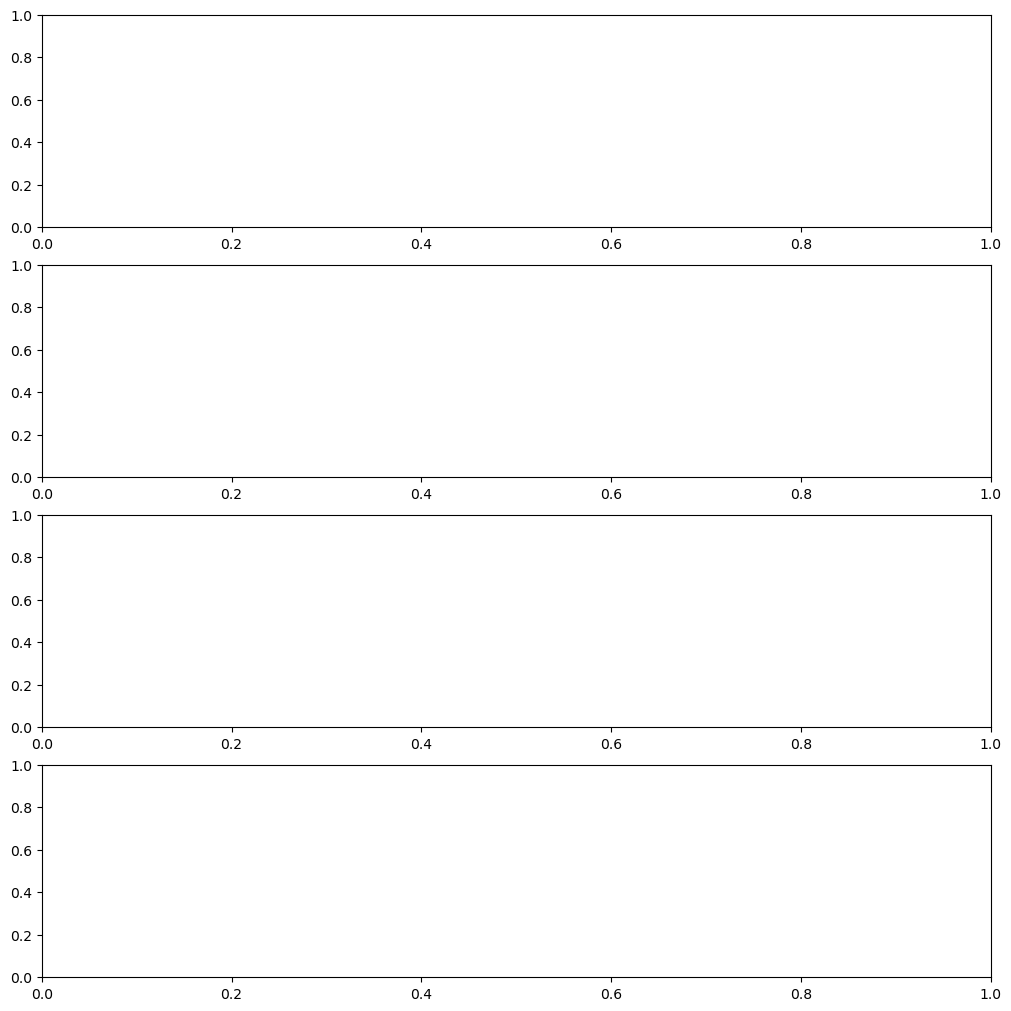

In [10]:
#-- 2D histplot testing
import matplotlib as mpl

fig, ax = plt.subplots(nrows = 4, ncols=1, figsize=(10,10), constrained_layout = True)

ax[0].hist2d(microphy_df['Temperature (Celsius)'], microphy_df['Number Conc corr (#/cm^3)'], 
             norm=mpl.colors.LogNorm(), cmap=plt.cm.Blues)
ax[0].set_ylabel('Number Conc corr (#/cm^3)')
ax[0].set_xlabel('Temperature (C)')
ax[0].set_title('All flights')

for count, surf_type in enumerate(cats):
    # Create similar plots for each of the surface types
    plot_df = microphy_df[microphy_df['surf_cond']==surf_type]
    row_n = count+1
    ax[row_n].hist2d(plot_df['Temperature (Celsius)'], plot_df['cip Number Conc corr (#/cm^3)'], 
                     norm=mpl.colors.LogNorm(), cmap=plt.cm.Blues)
    ax[row_n].set_ylabel('Number Conc corr (#/cm^3)')
    ax[row_n].set_xlabel('Temperature (C)')
    ax[row_n].set_title(surf_type)


plt.savefig('SLF_2Dhist.png')
plt.show()

In [43]:
microphy_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cdp MVD (um)', 'Cloud_pos',
       'Relevance', 'cip NumConc (#/cm^3)', 'tot NumConc (#/cm3)',
       'TWC (gram/m3)', 'incloud', 'TWC_RM', 'LWC_RM', 'T_RM', 'temp_cat',
       'InCloudTimeStep', 'surf_cond'],
      dtype='object')

KeyError: 'SLF'

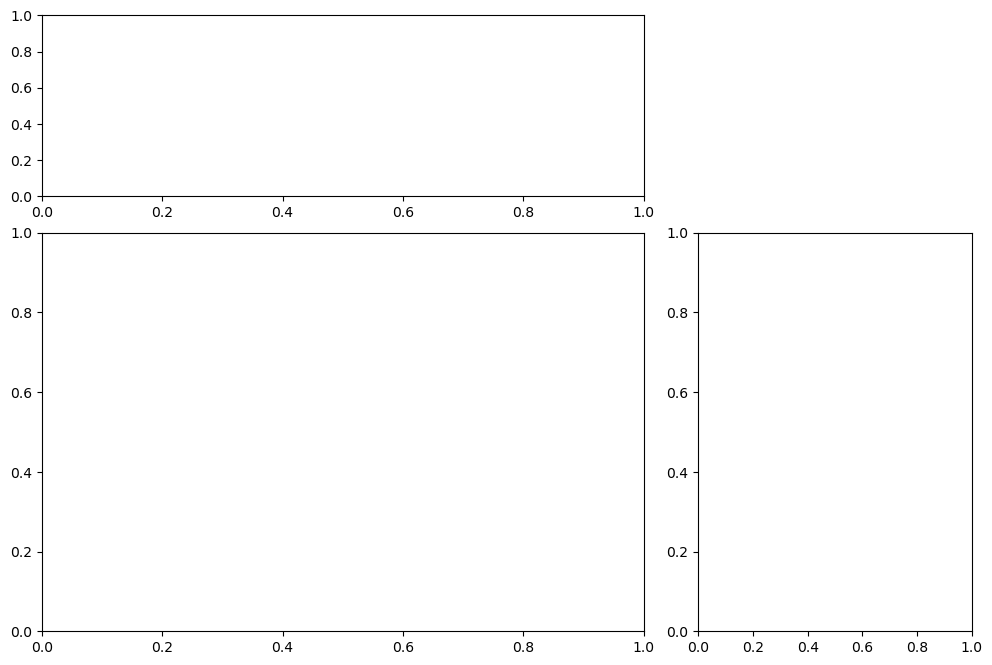

In [44]:
# testing marginal plot with matplotlib only

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
ax_main.hist2d(microphy_df['Temperature (Celsius)'], microphy_df['SLF'], 
             bins=(40, 20), range=[[-40,0],[0,100]],
             cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_main.set_ylabel('SLF %')
ax_main.set_xlabel('Temperature (C)')


ax_xDist.hist(microphy_df['Temperature (Celsius)'],bins=40, align='left')
ax_xDist.set(ylabel='count')

ax_yDist.hist(microphy_df['SLF'],bins=20,orientation='horizontal', density = True)
ax_yDist.set(xlabel='count')

fig.suptitle('All flights')
plt.savefig('test_marginal_all_fligths.png')
plt.show()

In [45]:
# Marginal plot function

def slf_marg_plot(df, title):
    import matplotlib.gridspec as gridspec
    
    fig = plt.figure(figsize=(12,8))

    plt.rcParams['font.size'] = 18
    
    gs = gridspec.GridSpec(3, 3)
    ax_main = plt.subplot(gs[1:3, :2])
    ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
        
    ax_main.hist2d(df['Temperature (Celsius)'], df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
    ax_main.set_ylabel('SLF %')
    ax_main.set_xlabel('Temperature (C)')
    
    
    ax_xDist.hist(df['Temperature (Celsius)'],bins=20, align='left')
    ax_xDist.set(ylabel='count')
    
    ax_yDist.hist(df['SLF'],bins=20,orientation='horizontal')
    ax_yDist.set(xlabel='count')
    
    fig.suptitle(title, fontsize = 'large')
    plt.show()
    return(fig)

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_4559/2796372515.py:3: SyntaxWarning: invalid escape sequence '\c'
  fig = slf_marg_plot(microphy_df, 'SLF per 2$^\circ$C temperature bins over all surfaces')
/tmp/ipykernel_4559/2796372515.py:7: SyntaxWarning: invalid escape sequence '\c'
  fig = slf_marg_plot(microphy_df[microphy_df['surf_cond']=='land-main'], 'SLF per 2$^\circ$C temperature bins over land')
/tmp/ipykernel_4559/2796372515.py:11: SyntaxWarning: invalid escape sequence '\c'
  fig = slf_marg_plot(microphy_df[microphy_df['surf_cond']=='sea-ocean'], 'SLF per 2$^\circ$C temperature bins over open ocean')
/tmp/ipy

KeyError: 'SLF'

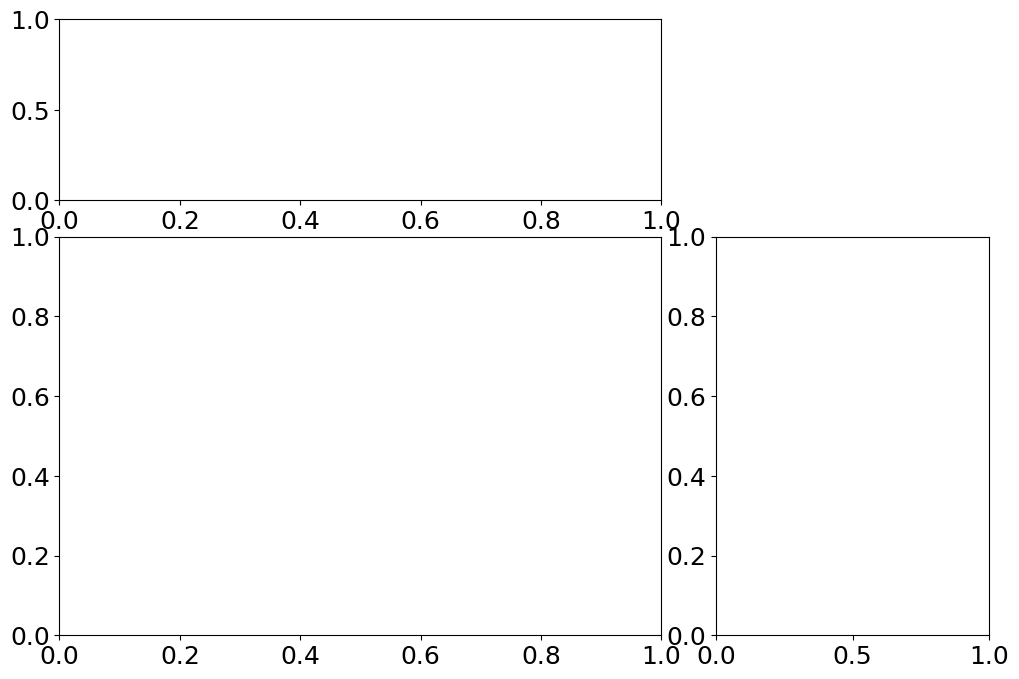

In [46]:
# SLF marginal plot for all surfaces, separately and total
# plot for all surfaces
fig = slf_marg_plot(microphy_df, 'SLF per 2$^\circ$C temperature bins over all surfaces')
fig.savefig('slf_margplot_all_flights.png')

# plot for land
fig = slf_marg_plot(microphy_df[microphy_df['surf_cond']=='land-main'], 'SLF per 2$^\circ$C temperature bins over land')
fig.savefig('slf_margplot_land.png')

# plot for ocean
fig = slf_marg_plot(microphy_df[microphy_df['surf_cond']=='sea-ocean'], 'SLF per 2$^\circ$C temperature bins over open ocean')
fig.savefig('slf_margplot_ocean.png')

# plot for sea-ice
fig = slf_marg_plot(microphy_df[microphy_df['surf_cond']=='sea-ice'], 'SLF per 2$^\circ$C temperature bins over sea-ice')
fig.savefig('slf_margplot_sea_ice.png')


In [62]:
microphy_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cdp MVD (um)', 'Cloud_pos',
       'Relevance', 'cip NumConc (#/cm^3)', 'tot NumConc (#/cm3)',
       'TWC (gram/m3)', 'incloud', 'InCloudTimeStep', 'TWC_RM', 'LWC_RM',
       'T_RM', 'temp_cat', 'surf_cond'],
      dtype='object')

In [63]:
# plotting separated by cloud position:

# plot for all is the same as the other one

# plot for Top
fig = slf_marg_plot(microphy_df[microphy_df['altitude_category']=='Top'], 'SLF per 2$^\circ$C temperature bins for cloud position: Top')
fig.savefig('slf_margplot_top.png')

# plot for ocean
fig = slf_marg_plot(microphy_df[microphy_df['altitude_category']=='Bulk'], 'SLF per 2$^\circ$C temperature bins for cloud position: Bulk')
fig.savefig('slf_margplot_bulk.png')

# plot for sea-ice
fig = slf_marg_plot(microphy_df[microphy_df['altitude_category']=='Base'], 'SLF per 2$^\circ$C temperature bins for cloud position: Base')
fig.savefig('slf_margplot_base.png')

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:10: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:10: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_20784/2974423573.py:6: SyntaxWarning: invalid escape sequence '\c'
  fig = slf_marg_plot(microphy_df[microphy_df['altitude_category']=='Top'], 'SLF per 2$^\circ$C temperature bins for cloud position: Top')
/tmp/ipykernel_20784/2974423573.py:10: SyntaxWarning: invalid escape sequence '\c'
  fig = slf_marg_plot(microphy_df[microphy_df['altitude_category']=='Bulk'], 'SLF per 2$^\circ$C temperature bins for cloud position: Bulk')
/tmp/ipykernel_20784/2974423573.py:14: SyntaxWarning: invalid escape sequence '\c'
  fig = slf_marg_plot(microphy_df[microphy_df['altitude_category']=='Base'], 'SLF per 2$^\circ$C temperature bins for cloud position: Base')
/tmp/ipykernel_20784/297442

KeyError: 'altitude_category'

In [64]:
# Barplot 
# bar graph with 4 bars showing the mean SLF for each temperature interval (one for each surface type + overall). 

# define data
labels = surf_stat_dict['sea-ice'].temp_cat
land = surf_stat_dict['land-main'].SLF
ocean = surf_stat_dict['sea-ocean'].SLF
sea_ice = surf_stat_dict['sea-ice'].SLF
all = surf_stat_dict['All surfaces'].SLF

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Set position of bar on X axis
r1 = np.arange(len(land))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]

fig, ax = plt.subplots()
rects1 = ax.bar(r1, land, width, label='Land')
rects2 = ax.bar(r2, ocean, width, label='Ocean')
rects3 = ax.bar(r3, sea_ice, width, label='Sea-ice')
rects4 = ax.bar(r4, all, width, label='All surfaces')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median SLF [%]')
ax.set_title('Median SLF per temperature grouped by surface type')
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + width for r in range(len(land))], labels)

ax.legend()

fig.tight_layout()
plt.savefig('SLF_surface_barplot2.png')
plt.show()


NameError: name 'surf_stat_dict' is not defined

In [65]:
# Marginal plot function

def slf_marg_plot(df, title):
    import matplotlib.gridspec as gridspec
    
    fig = plt.figure(figsize=(12,8))

    plt.rcParams['font.size'] = 18
    
    gs = gridspec.GridSpec(3, 3)
    ax_main = plt.subplot(gs[1:3, :2])
    ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
        
    ax_main.hist2d(df['Temperature (Celsius)'], df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
    ax_main.set_ylabel('SLF %')
    ax_main.set_xlabel('Temperature (C)')
    
    
    ax_xDist.hist(df['Temperature (Celsius)'],bins=20, align='left')
    ax_xDist.set(ylabel='count')
    
    ax_yDist.hist(df['SLF'],bins=20,orientation='horizontal')
    ax_yDist.set(xlabel='count')
    
    fig.suptitle(title, fontsize = 'large')
    plt.show()
    return(fig)

In [66]:
# select out the different categories of data

# Select: cloud altitude: Top
top_land_df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['altitude_category']=='Top') & (microphy_df['surf_cond']=='land')]
tl_datapoints = len(top_land_df)

top_sea_df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['altitude_category']=='Top') & (microphy_df['surf_cond']=='sea-ocean')]
ts_datapoints = len(top_sea_df)

top_seaice_df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['altitude_category']=='Top') & (microphy_df['surf_cond']=='sea-ice')]
tsi_datapoints = len(top_seaice_df)

# Select: cloud altitude: Bulk
bulk_land_df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['altitude_category']=='Bulk') & (microphy_df['surf_cond']=='land')]
bkl_datapoints = len(bulk_land_df)

bulk_sea_df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['altitude_category']=='Bulk') & (microphy_df['surf_cond']=='sea-ocean')]
bks_datapoints = len(bulk_sea_df)

bulk_seaice_df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['altitude_category']=='Bulk') & (microphy_df['surf_cond']=='sea-ice')]
bksi_datapoints = len(bulk_seaice_df)

# Select: cloud altitude: Base
base_land_df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['altitude_category']=='Base') & (microphy_df['surf_cond']=='land')]
bl_datapoints = len(base_land_df)

base_sea_df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['altitude_category']=='Base') & (microphy_df['surf_cond']=='sea-ocean')]
bs_datapoints = len(base_sea_df)

base_seaice_df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['altitude_category']=='Base') & (microphy_df['surf_cond']=='sea-ice')]
bsi_datapoints = len(base_seaice_df)

KeyError: 'altitude_category'

In [67]:
top_sea_df

NameError: name 'top_sea_df' is not defined

In [68]:
# Barplot for showing the counts per category
alt_cat = ("Top", "Bulk", "Base")
surf_cat_count = {
    'Land': (tl_datapoints, bkl_datapoints, bl_datapoints),
    'Ocean': (ts_datapoints, bks_datapoints, bs_datapoints),
    'Sea-ice': (tsi_datapoints, bksi_datapoints, bsi_datapoints),
}


x = np.arange(len(alt_cat))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in surf_cat_count.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Datapoints per category combination')
ax.set_xticks(x + width, alt_cat)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 2500)


NameError: name 'tl_datapoints' is not defined

NameError: name 'top_land_df' is not defined

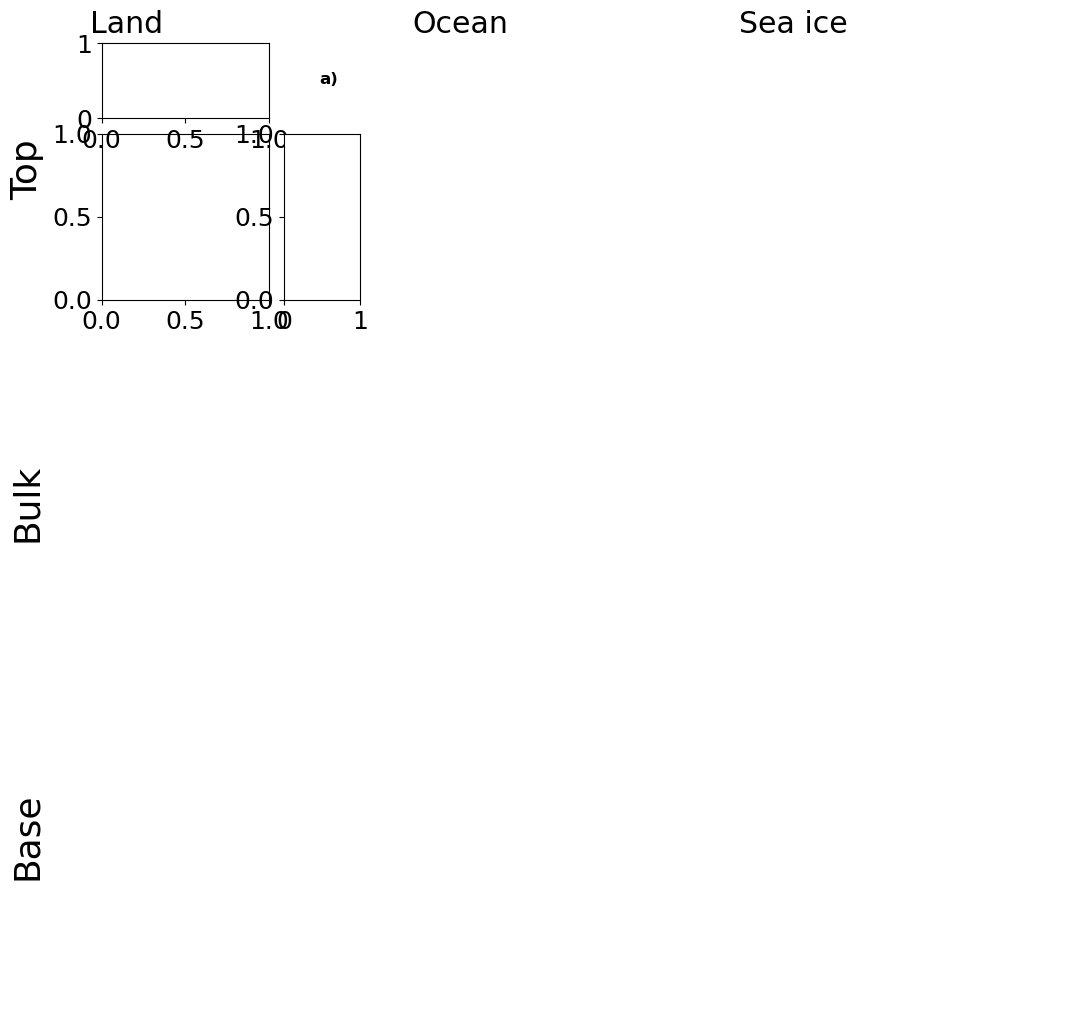

In [69]:
# Huge multifigure for SLF (surface vs place in cloud grid)
def letter_annotation(ax, xoffset, yoffset, letter):
    # function to properly format letter for adding to subfigure
 ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
         size=12, weight='bold')

fig = plt.figure(figsize=(10,10))

# creating subfigures for the three rows/ in cloud height category
(row_top_fig, row_bulk_fig, row_base_fig) = fig.subfigures(3, 1)
#
row_top_fig.supylabel('Top', x = -0.05, y=0.5, size='x-large')
row_bulk_fig.supylabel('Bulk', x = -0.05, y=0.5, size='x-large')
row_base_fig.supylabel('Base', x = -0.05, y=0.5, size='x-large')

# splitting each row into tree subfigures
(topland_fig, topsea_fig, topice_fig) = row_top_fig.subfigures(1, 3)
(bulkland_fig, bulksea_fig, bulkice_fig) = row_bulk_fig.subfigures(1, 3)
(baseland_fig, basesea_fig, baseice_fig) = row_base_fig.subfigures(1, 3)

# Set titles to the subfigures
topland_fig.suptitle('Land', x= 0.2)
topsea_fig.suptitle('Ocean', x= 0.2)
topice_fig.suptitle('Sea ice', x= 0.2)

# x-axis settings for marginal plot: SLF/right plot
slf_xax =[0,0.4] # setting the x-axis manually
slf_xax_xtic = [0, 0.25]
slf_xax_lab = ['0', '0.25']

# ---- Top Row ---
# Top - Land
gs = gridspec.GridSpec(3, 3)
ax_tl_main = topland_fig.add_subplot(gs[1:3, :2])
ax_tl_xDist = topland_fig.add_subplot(gs[0, :2],sharex=ax_tl_main)
ax_tl_yDist = topland_fig.add_subplot(gs[1:3, 2],sharey=ax_tl_main)
letter_annotation(ax_tl_main, 1.3, 1.3, 'a)')

ax_tl_main.hist2d(top_land_df['Temperature (Celsius)'], top_land_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_tl_main.set_ylabel('SLF %')
ax_tl_main.set_xlabel('Temperature (C)')
    
ax_tl_xDist.hist(top_land_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_tl_xDist.set(ylabel='count')
    
ax_tl_yDist.hist(top_land_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_tl_yDist.set(xlabel='count')
ax_tl_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_tl_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_tl_xDist.get_xticklabels(), visible=False)
plt.setp(ax_tl_yDist.get_yticklabels(), visible=False)
plt.setp(ax_tl_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_tl_yDist.get_yticklabels(minor=True), visible=False)

# Top - Ocean
gs = gridspec.GridSpec(3, 3)
ax_to_main = topsea_fig.add_subplot(gs[1:3, :2])
ax_to_xDist = topsea_fig.add_subplot(gs[0, :2],sharex=ax_to_main)
ax_to_yDist = topsea_fig.add_subplot(gs[1:3, 2],sharey=ax_to_main)
letter_annotation(ax_to_main, 1.3, 1.3, 'b)')

ax_to_main.hist2d(top_sea_df['Temperature (Celsius)'], top_sea_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_to_main.set_ylabel('SLF %')
ax_to_main.set_xlabel('Temperature (C)')
    
ax_to_xDist.hist(top_sea_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_to_xDist.set(ylabel='count')
    
ax_to_yDist.hist(top_sea_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_to_yDist.set(xlabel='count')
ax_to_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_to_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_to_xDist.get_xticklabels(), visible=False)
plt.setp(ax_to_yDist.get_yticklabels(), visible=False)
plt.setp(ax_to_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_to_yDist.get_yticklabels(minor=True), visible=False)

# Top - Sea-ice
gs = gridspec.GridSpec(3, 3)
ax_ti_main = topice_fig.add_subplot(gs[1:3, :2])
ax_ti_xDist = topice_fig.add_subplot(gs[0, :2],sharex=ax_ti_main)
ax_ti_yDist = topice_fig.add_subplot(gs[1:3, 2],sharey=ax_ti_main)
letter_annotation(ax_ti_main, 1.3, 1.3, 'c)')

ax_ti_main.hist2d(top_seaice_df['Temperature (Celsius)'], top_seaice_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_ti_main.set_ylabel('SLF %')
ax_ti_main.set_xlabel('Temperature (C)')
    
ax_ti_xDist.hist(top_seaice_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_ti_xDist.set(ylabel='count')
    
ax_ti_yDist.hist(top_seaice_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_ti_yDist.set(xlabel='count')
ax_ti_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_ti_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_ti_xDist.get_xticklabels(), visible=False)
plt.setp(ax_ti_yDist.get_yticklabels(), visible=False)
plt.setp(ax_ti_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_ti_yDist.get_yticklabels(minor=True), visible=False)

# ---- Bulk Row ---
# Bulk - Land
gs = gridspec.GridSpec(3, 3)
ax_bkl_main = bulkland_fig.add_subplot(gs[1:3, :2])
ax_bkl_xDist = bulkland_fig.add_subplot(gs[0, :2],sharex=ax_tl_main)
ax_bkl_yDist = bulkland_fig.add_subplot(gs[1:3, 2],sharey=ax_tl_main)
letter_annotation(ax_bkl_main, 1.3, 1.3, 'd)')

ax_bkl_main.hist2d(bulk_land_df['Temperature (Celsius)'], bulk_land_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bkl_main.set_ylabel('SLF %')
ax_bkl_main.set_xlabel('Temperature (C)')
    
ax_bkl_xDist.hist(bulk_land_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bkl_xDist.set(ylabel='count')
    
ax_bkl_yDist.hist(bulk_land_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bkl_yDist.set(xlabel='count')
ax_bkl_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bkl_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bkl_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bkl_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bkl_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bkl_yDist.get_yticklabels(minor=True), visible=False)

# Bulk - Ocean
gs = gridspec.GridSpec(3, 3)
ax_bko_main = bulksea_fig.add_subplot(gs[1:3, :2])
ax_bko_xDist = bulksea_fig.add_subplot(gs[0, :2],sharex=ax_to_main)
ax_bko_yDist = bulksea_fig.add_subplot(gs[1:3, 2],sharey=ax_to_main)
letter_annotation(ax_bko_main, 1.3, 1.3, 'e)')

ax_bko_main.hist2d(bulk_sea_df['Temperature (Celsius)'], bulk_sea_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bko_main.set_ylabel('SLF %')
ax_bko_main.set_xlabel('Temperature (C)')
    
ax_bko_xDist.hist(bulk_sea_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bko_xDist.set(ylabel='count')
    
ax_bko_yDist.hist(bulk_sea_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bko_yDist.set(xlabel='count')
ax_bko_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bko_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bko_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bko_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bko_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bko_yDist.get_yticklabels(minor=True), visible=False)

# Bulk - Sea-ice
gs = gridspec.GridSpec(3, 3)
ax_bki_main = bulkice_fig.add_subplot(gs[1:3, :2])
ax_bki_xDist = bulkice_fig.add_subplot(gs[0, :2],sharex=ax_ti_main)
ax_bki_yDist = bulkice_fig.add_subplot(gs[1:3, 2],sharey=ax_ti_main)
letter_annotation(ax_bki_main, 1.3, 1.3, 'f)')

ax_bki_main.hist2d(bulk_seaice_df['Temperature (Celsius)'], bulk_seaice_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bki_main.set_ylabel('SLF %')
ax_bki_main.set_xlabel('Temperature (C)')
    
ax_bki_xDist.hist(bulk_seaice_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bki_xDist.set(ylabel='count')
    
ax_bki_yDist.hist(bulk_seaice_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bki_yDist.set(xlabel='count')
ax_bki_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bki_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bki_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bki_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bki_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bki_yDist.get_yticklabels(minor=True), visible=False)

# ---- Base Row ---
# Base - Land
gs = gridspec.GridSpec(3, 3)
ax_bl_main = baseland_fig.add_subplot(gs[1:3, :2])
ax_bl_xDist = baseland_fig.add_subplot(gs[0, :2],sharex=ax_tl_main)
ax_bl_yDist = baseland_fig.add_subplot(gs[1:3, 2],sharey=ax_tl_main)
letter_annotation(ax_bl_main, 1.3, 1.3, 'g)')

ax_bl_main.hist2d(base_land_df['Temperature (Celsius)'], base_land_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bl_main.set_ylabel('SLF %')
ax_bl_main.set_xlabel('Temperature (C)')
    
ax_bl_xDist.hist(base_land_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bl_xDist.set(ylabel='count')
ax_bl_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bl_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)
    
ax_bl_yDist.hist(base_land_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bl_yDist.set(xlabel='count')

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bl_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bl_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bl_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bl_yDist.get_yticklabels(minor=True), visible=False)

# base - Ocean
gs = gridspec.GridSpec(3, 3)
ax_bo_main = basesea_fig.add_subplot(gs[1:3, :2])
ax_bo_xDist = basesea_fig.add_subplot(gs[0, :2],sharex=ax_to_main)
ax_bo_yDist = basesea_fig.add_subplot(gs[1:3, 2],sharey=ax_to_main)
letter_annotation(ax_bo_main, 1.3, 1.3, 'h)')

ax_bo_main.hist2d(base_sea_df['Temperature (Celsius)'], base_sea_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bo_main.set_ylabel('SLF %')
ax_bo_main.set_xlabel('Temperature (C)')
    
ax_bo_xDist.hist(base_sea_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bo_xDist.set(ylabel='count')
    
ax_bo_yDist.hist(base_sea_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bo_yDist.set(xlabel='count')
ax_bo_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bo_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bo_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bo_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bo_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bo_yDist.get_yticklabels(minor=True), visible=False)

# base - Sea-ice
gs = gridspec.GridSpec(3, 3)
ax_bi_main = baseice_fig.add_subplot(gs[1:3, :2])
ax_bi_xDist = baseice_fig.add_subplot(gs[0, :2],sharex=ax_ti_main)
ax_bi_yDist = baseice_fig.add_subplot(gs[1:3, 2],sharey=ax_ti_main)
letter_annotation(ax_bi_main, 1.3, 1.3, 'i)')

ax_bi_main.hist2d(base_seaice_df['Temperature (Celsius)'], base_seaice_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bi_main.set_ylabel('SLF %')
ax_bi_main.set_xlabel('Temperature (C)')
    
ax_bi_xDist.hist(base_seaice_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bi_xDist.set(ylabel='count')
    
ax_bi_yDist.hist(base_seaice_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bi_yDist.set(xlabel='count')
ax_bi_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bi_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bi_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bi_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bi_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bi_yDist.get_yticklabels(minor=True), visible=False)

plt.show()

NameError: name 'top_land_df' is not defined

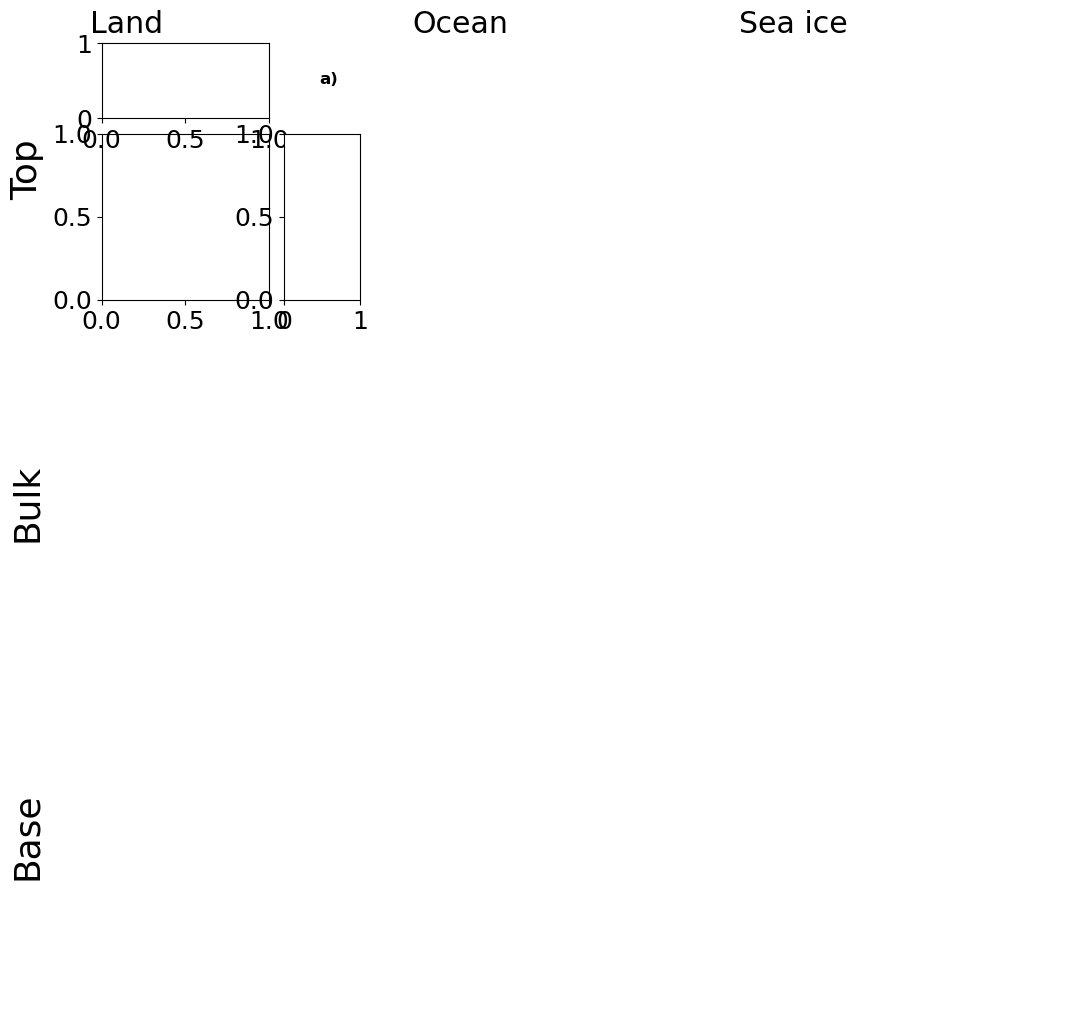

In [70]:
# Huge multifigure number concentration (surface vs place in cloud grid)



fig = plt.figure(figsize=(10,10))

# creating subfigures for the three rows/ in cloud height category
(row_top_fig, row_bulk_fig, row_base_fig) = fig.subfigures(3, 1)
#
row_top_fig.supylabel('Top', x = -0.05, y=0.5, size='x-large')
row_bulk_fig.supylabel('Bulk', x = -0.05, y=0.5, size='x-large')
row_base_fig.supylabel('Base', x = -0.05, y=0.5, size='x-large')

# splitting each row into tree subfigures
(topland_fig, topsea_fig, topice_fig) = row_top_fig.subfigures(1, 3)
(bulkland_fig, bulksea_fig, bulkice_fig) = row_bulk_fig.subfigures(1, 3)
(baseland_fig, basesea_fig, baseice_fig) = row_base_fig.subfigures(1, 3)

# Set titles to the subfigures
topland_fig.suptitle('Land', x= 0.2)
topsea_fig.suptitle('Ocean', x= 0.2)
topice_fig.suptitle('Sea ice', x= 0.2)


# ---- Top Row ---
# Top - Land
gs = gridspec.GridSpec(3, 3)
ax_tl_main = topland_fig.add_subplot(gs[1:3, :2])
ax_tl_xDist = topland_fig.add_subplot(gs[0, :2],sharex=ax_tl_main)
ax_tl_yDist = topland_fig.add_subplot(gs[1:3, 2],sharey=ax_tl_main)
letter_annotation(ax_tl_main, 1.3, 1.3, 'a)')

ax_tl_main.hist2d(top_land_df['Temperature (Celsius)'], top_land_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_tl_main.set_ylabel('SLF %')
ax_tl_main.set_xlabel('Temperature (C)')
    
ax_tl_xDist.hist(top_land_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_tl_xDist.set(ylabel='count')
    
ax_tl_yDist.hist(top_land_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_tl_yDist.set(xlabel='count')
ax_tl_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_tl_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_tl_xDist.get_xticklabels(), visible=False)
plt.setp(ax_tl_yDist.get_yticklabels(), visible=False)
plt.setp(ax_tl_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_tl_yDist.get_yticklabels(minor=True), visible=False)

# Top - Ocean
gs = gridspec.GridSpec(3, 3)
ax_to_main = topsea_fig.add_subplot(gs[1:3, :2])
ax_to_xDist = topsea_fig.add_subplot(gs[0, :2],sharex=ax_to_main)
ax_to_yDist = topsea_fig.add_subplot(gs[1:3, 2],sharey=ax_to_main)
letter_annotation(ax_to_main, 1.3, 1.3, 'b)')

ax_to_main.hist2d(top_sea_df['Temperature (Celsius)'], top_sea_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_to_main.set_ylabel('SLF %')
ax_to_main.set_xlabel('Temperature (C)')
    
ax_to_xDist.hist(top_sea_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_to_xDist.set(ylabel='count')
    
ax_to_yDist.hist(top_sea_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_to_yDist.set(xlabel='count')
ax_to_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_to_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_to_xDist.get_xticklabels(), visible=False)
plt.setp(ax_to_yDist.get_yticklabels(), visible=False)
plt.setp(ax_to_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_to_yDist.get_yticklabels(minor=True), visible=False)

# Top - Sea-ice
gs = gridspec.GridSpec(3, 3)
ax_ti_main = topice_fig.add_subplot(gs[1:3, :2])
ax_ti_xDist = topice_fig.add_subplot(gs[0, :2],sharex=ax_ti_main)
ax_ti_yDist = topice_fig.add_subplot(gs[1:3, 2],sharey=ax_ti_main)
letter_annotation(ax_ti_main, 1.3, 1.3, 'c)')

ax_ti_main.hist2d(top_seaice_df['Temperature (Celsius)'], top_seaice_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_ti_main.set_ylabel('SLF %')
ax_ti_main.set_xlabel('Temperature (C)')
    
ax_ti_xDist.hist(top_seaice_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_ti_xDist.set(ylabel='count')
    
ax_ti_yDist.hist(top_seaice_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_ti_yDist.set(xlabel='count')
ax_ti_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_ti_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_ti_xDist.get_xticklabels(), visible=False)
plt.setp(ax_ti_yDist.get_yticklabels(), visible=False)
plt.setp(ax_ti_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_ti_yDist.get_yticklabels(minor=True), visible=False)

# ---- Bulk Row ---
# Bulk - Land
gs = gridspec.GridSpec(3, 3)
ax_bkl_main = bulkland_fig.add_subplot(gs[1:3, :2])
ax_bkl_xDist = bulkland_fig.add_subplot(gs[0, :2],sharex=ax_tl_main)
ax_bkl_yDist = bulkland_fig.add_subplot(gs[1:3, 2],sharey=ax_tl_main)
letter_annotation(ax_bkl_main, 1.3, 1.3, 'd)')

ax_bkl_main.hist2d(bulk_land_df['Temperature (Celsius)'], bulk_land_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bkl_main.set_ylabel('SLF %')
ax_bkl_main.set_xlabel('Temperature (C)')
    
ax_bkl_xDist.hist(bulk_land_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bkl_xDist.set(ylabel='count')
    
ax_bkl_yDist.hist(bulk_land_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bkl_yDist.set(xlabel='count')
ax_bkl_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bkl_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bkl_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bkl_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bkl_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bkl_yDist.get_yticklabels(minor=True), visible=False)

# Bulk - Ocean
gs = gridspec.GridSpec(3, 3)
ax_bko_main = bulksea_fig.add_subplot(gs[1:3, :2])
ax_bko_xDist = bulksea_fig.add_subplot(gs[0, :2],sharex=ax_to_main)
ax_bko_yDist = bulksea_fig.add_subplot(gs[1:3, 2],sharey=ax_to_main)
letter_annotation(ax_bko_main, 1.3, 1.3, 'e)')

ax_bko_main.hist2d(bulk_sea_df['Temperature (Celsius)'], bulk_sea_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bko_main.set_ylabel('SLF %')
ax_bko_main.set_xlabel('Temperature (C)')
    
ax_bko_xDist.hist(bulk_sea_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bko_xDist.set(ylabel='count')
    
ax_bko_yDist.hist(bulk_sea_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bko_yDist.set(xlabel='count')
ax_bko_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bko_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bko_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bko_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bko_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bko_yDist.get_yticklabels(minor=True), visible=False)

# Bulk - Sea-ice
gs = gridspec.GridSpec(3, 3)
ax_bki_main = bulkice_fig.add_subplot(gs[1:3, :2])
ax_bki_xDist = bulkice_fig.add_subplot(gs[0, :2],sharex=ax_ti_main)
ax_bki_yDist = bulkice_fig.add_subplot(gs[1:3, 2],sharey=ax_ti_main)
letter_annotation(ax_bki_main, 1.3, 1.3, 'f)')

ax_bki_main.hist2d(bulk_seaice_df['Temperature (Celsius)'], bulk_seaice_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bki_main.set_ylabel('SLF %')
ax_bki_main.set_xlabel('Temperature (C)')
    
ax_bki_xDist.hist(bulk_seaice_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bki_xDist.set(ylabel='count')
    
ax_bki_yDist.hist(bulk_seaice_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bki_yDist.set(xlabel='count')
ax_bki_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bki_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bki_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bki_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bki_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bki_yDist.get_yticklabels(minor=True), visible=False)

# ---- Base Row ---
# Base - Land
gs = gridspec.GridSpec(3, 3)
ax_bl_main = baseland_fig.add_subplot(gs[1:3, :2])
ax_bl_xDist = baseland_fig.add_subplot(gs[0, :2],sharex=ax_tl_main)
ax_bl_yDist = baseland_fig.add_subplot(gs[1:3, 2],sharey=ax_tl_main)
letter_annotation(ax_bl_main, 1.3, 1.3, 'g)')

ax_bl_main.hist2d(base_land_df['Temperature (Celsius)'], base_land_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bl_main.set_ylabel('SLF %')
ax_bl_main.set_xlabel('Temperature (C)')
    
ax_bl_xDist.hist(base_land_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bl_xDist.set(ylabel='count')
ax_bl_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bl_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)
    
ax_bl_yDist.hist(base_land_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bl_yDist.set(xlabel='count')

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bl_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bl_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bl_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bl_yDist.get_yticklabels(minor=True), visible=False)

# base - Ocean
gs = gridspec.GridSpec(3, 3)
ax_bo_main = basesea_fig.add_subplot(gs[1:3, :2])
ax_bo_xDist = basesea_fig.add_subplot(gs[0, :2],sharex=ax_to_main)
ax_bo_yDist = basesea_fig.add_subplot(gs[1:3, 2],sharey=ax_to_main)
letter_annotation(ax_bo_main, 1.3, 1.3, 'h)')

ax_bo_main.hist2d(base_sea_df['Temperature (Celsius)'], base_sea_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bo_main.set_ylabel('SLF %')
ax_bo_main.set_xlabel('Temperature (C)')
    
ax_bo_xDist.hist(base_sea_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bo_xDist.set(ylabel='count')
    
ax_bo_yDist.hist(base_sea_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bo_yDist.set(xlabel='count')
ax_bo_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bo_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bo_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bo_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bo_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bo_yDist.get_yticklabels(minor=True), visible=False)

# base - Sea-ice
gs = gridspec.GridSpec(3, 3)
ax_bi_main = baseice_fig.add_subplot(gs[1:3, :2])
ax_bi_xDist = baseice_fig.add_subplot(gs[0, :2],sharex=ax_ti_main)
ax_bi_yDist = baseice_fig.add_subplot(gs[1:3, 2],sharey=ax_ti_main)
letter_annotation(ax_bi_main, 1.3, 1.3, 'i)')

ax_bi_main.hist2d(base_seaice_df['Temperature (Celsius)'], base_seaice_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bi_main.set_ylabel('SLF %')
ax_bi_main.set_xlabel('Temperature (C)')
    
ax_bi_xDist.hist(base_seaice_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bi_xDist.set(ylabel='count')
    
ax_bi_yDist.hist(base_seaice_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bi_yDist.set(xlabel='count')
ax_bi_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bi_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bi_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bi_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bi_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bi_yDist.get_yticklabels(minor=True), visible=False)

plt.show()

In [ ]:
# ---- Testing things

In [ ]:
# --- Total number concentration for in-cloud values (statistics)
# select only the rows where TWC is above threshold
in_cloud_sl_df = microphy_df[microphy_df['TWC (gram/m3)']>in_cl_th]
print('CIP and CDP \n -----------')
print(f'ISLAS: {in_cloud_sl_df['tot NT (#/cm3)'].describe()}')
print(in_cloud_sl_df.groupby('flightid', observed=True)['tot NT (#/cm3)'].describe())

print('\n\n Just CDP \n ------------')
# for just the CDP (above 5 microns)
print(f'ISLAS: {in_cloud_sl_df['Number Conc corr (#/cm^3)'].describe()}')
print(in_cloud_sl_df.groupby('flightid', observed=True)['Number Conc corr (#/cm^3)'].describe())

## Testing sea-ice data


In [ ]:
# Get the date from a specific flightid
flightid= 'as220015'

sic_colum_list = [] # list to hold the values for all the flights

for flight in flights:
       
    # get the time column of the first row (the lowest) for the flightid and format to string: YYYYMMDD
    date = in_cloud_sl_df['time'][in_cloud_sl_df['flightid']==flight].min().strftime("%Y%m%d")
    print(f'flight: {flight}, date: {date}')

    # get a dataframe consisting of time, latitude and longitude for the given flight
    df = in_cloud_sl_df[in_cloud_sl_df['flightid']=='as220015'][['time','Latitude (degree)','Longitude (degree)']]
    #print(df.head())

    # get the sea-ice concentration data for the date associated with the flight
    sic_ds = read_sic(date)
    # List to hold interpolated values
    interpolerte_sic = []

    # calculate interpolated values of sic for lat,lon from each row of df 
    for idx, rad in df.iterrows():
        lat, lon = rad['Latitude (degree)'], rad['Longitude (degree)']
        sic_verdi = sic_ds['sic'].interp(lat=lat, lon=lon).values
        interpolerte_sic.append(sic_verdi)
    
    # Add interpolated values as a new column of the dataframe containing time and coordinates
    df['sic'] = interpolerte_sic
    # Add the dataframe from this flight to the total
    sic_colum_list.append(df)

sic_colum_list['sic'].
    
sic_colum_list.toDataFrame()
sic_ds = read_sic('20220403')
sic_ds

In [ ]:
# Liste for å holde interpolerte verdier
interpolerte_sic = []

for idx, rad in df.iterrows():
    lat, lon = rad['Latitude (degree)'], rad['Longitude (degree)']
    sic_verdi = sic_ds['sic'].interp(lat=lat, lon=lon).values
    interpolerte_sic.append(sic_verdi)

# Legg til denne listen som en ny kolonne til dataframen
df['sic'] = interpolerte_sic